# Inversion and Optimisation  <a class="tocSkip"></a>

# Homework Lecture 11: PDE-constrained Optimisation (solutions) <a class="tocSkip"></a>

<font size="1pt">Some $\LaTeX$ definitions hidden in this cell (double-click to reveal)</font>
$
\newcommand\vec[1]{\mathbf{#1}}
\newcommand\vphi{\boldsymbol{\phi}}
\newcommand\vsig{\boldsymbol{\sigma}}
\newcommand\vlam{\boldsymbol{\lambda}}
\newcommand\mat[1]{\underline{\mathbf{#1}}}
\newcommand\R{\mathbb{R}}
\newcommand\todo[1]{\textcolor{red}#1}
$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spl
import scipy.optimize as sop
import numpy as np

# ensure fonts in figures are readable:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

In [2]:
%matplotlib inline

# Diffusion Equation

We consider the diffusion equation

$$
  \frac{\partial u}{\partial t} - \kappa \frac{\partial^2}{\partial x^2} = s(x, t)
$$

which has many uses, such as the dispersal of microparticles 
through random motion (Brownian motion), the spread of a disolved substance, e.g. a pollutant, in a fluid, or the spread of heat. For the moment let's think of $u$ as a concentration. The coefficient $\kappa$ is the diffusion coefficient. We also consider a source term $s(x,t)$ which represent release of the concentration (can be a sink as well when negative).

This PDE comes with the following initial and boundary conditions:

$$
  u(x, 0) = u_{\text{ic}}(x), \text{ and } \\
  \kappa\left.\frac{\partial u(x,t)}{\partial x}\right|_{x=x_0} = \Phi_0 \text{ and }
  \kappa\left.\frac{\partial u(x,t)}{\partial x}\right|_{x=x_1} = \Phi_1
$$

Note that unlike for the advection equation example in the lecture notes we need a boundary condition on both sides of the domain which we assume is the interval $[x_0, x_1]$, and here we chose to apply a Neumann condition. The boundary values $\Phi_{0,1}$ represent the diffusive flux through both boundaries.

## Tangent linear approach

* we have observation data that tells us what the concentration $u(x,t)$ should be at $t=T$, say $u(x, T) \approx u_{\text{obs}}(x)$. We want to chance some parameters $m$ in our diffusion model to improve the match between the predicted concentration $u(x,t)$ predicted by the model and the observation. Write down what a suitable functional $f(u, m)$ would be for the associated optimisation problem

### Solution <a class="tocSkip"></a>
This is the same as for the advection example in the lecture notes, namely we take the (square of the) L2-norm of the mismatch:

$$
  f(u, m) = \int_0^L (u(x,T)-u_{\text{obs}}(x))^2 \mathrm{d}x
$$


* First we consider optimising the diffusion coefficient, so we choose $m$ to be a single parameter, $m=\kappa$, that we want to optimize to improve the match with observations. Write the PDE system as a constraint $g(u, m)$ similar to the advection example with an entry for the actual PDE, and entries for the initial and both boundary conditions.

### Solution <a class="tocSkip"></a>

$$
  g(u, m) = \begin{pmatrix}  
  \frac{\partial u}{\partial t} - m \frac{\partial^2 u}{\partial x^2} - s(x, t) \\
  u(\cdot, 0) - u_{\text{ic}}(\cdot) \\
  \kappa\left.\frac{\partial u(x,t)}{\partial x}\right|_{x=x_0} - \Phi_0 \\
  \kappa\left.\frac{\partial u(x,t)}{\partial x}\right|_{x=x_1} - \Phi_1
  \end{pmatrix} =
  \begin{pmatrix}
    0 \\ 0 \\ 0 \\0
  \end{pmatrix}
  \;\;\;
  \begin{array}{c}
    \text{PDE constraint} \\ \text{initial condition} \\
    \text{boundary condition at $x_0$} \\
    \text{boundary condition at $x_1$}
  \end{array}
$$

* In the lecture notes we saw that in the tangent linear approach we need to solve

$$
  \frac{\partial g}{\partial u}\delta u = -\frac{\partial g}{\partial m}\delta m
$$

to obtain the perturbation $\delta u$ in $u$ due to a perturbation $\delta m$ in $m$. In other words:

$$
  \delta u = \frac{du}{dm} \delta m
$$

Work out what the PDE is for $\delta u$, including initial and boundary conditions.

### Solution <a class="tocSkip"></a>
We have

$$
  \frac{\partial g(u, m)}{\partial u} \delta u = \begin{pmatrix}  
  \frac{\partial \delta u}{\partial t} - m\frac{\partial^2 \delta u}{\partial x^2} \\
  \delta u(\cdot, 0) \\
  m\left.\frac{\partial \delta u(x,t)}{\partial x}\right|_{x=x_0}  \\
  m\left.\frac{\partial \delta u(x,t)}{\partial x}\right|_{x=x_1}
  \end{pmatrix}
  \quad \text{ and } \quad
  \frac{\partial g(u, m)}{\partial m} \delta m = \begin{pmatrix}  
  -\delta m\frac{\partial^2 u}{\partial x^2} \\
  0 \\
  \delta m\left.\frac{\partial u(x,t)}{\partial x}\right|_{x=x_0} \\
  \delta m\left.\frac{\partial u(x,t)}{\partial x}\right|_{x=x_1}
  \end{pmatrix}
$$

As a PDE that becomes:

$$
  \frac{\partial \delta u}{\partial t} - m\frac{\partial^2 \delta u}{\partial x^2} 
  = \delta m\frac{\partial^2 u}{\partial x^2} 
$$

with initial and boundary conditions:

$$
  \delta u(x, 0) = 0, \text{ and } \\
  m\left.\frac{\partial\delta u(x,t)}{\partial x}\right|_{x=x_0} = 
  -\delta m\left.\frac{\partial u(x,t)}{\partial x}\right|_{x=x_0}
  \quad \text{ and } \quad
  m\left.\frac{\partial\delta u(x,t)}{\partial x}\right|_{x=x_1} = 
  -\delta m\left.\frac{\partial u(x,t)}{\partial x}\right|_{x=x_1}
$$

* Now, instead of the diffusivity coefficient, we want to invert for optimal boundary fluxes $\Phi_1$ and $\Phi_2$. We want to find the optimal *combination* of these two values, so we optimize for them simultaneously with $m=(\Phi_1, \Phi_2)$ now being a 2-vector. What is the consequence of this for the tangent-linear approach? You don't need to work out the new equations exactly (although it's a good exercise), just indicate what the main difference is with the previous case.

### Solution <a class="tocSkip"></a>
The short answer is that because we now have two optimisation parameters, we need to solve 
two separate PDEs for $\delta u_1$ and a $\delta u_2$:
    
$$
  \delta u_1 = \frac{du}{dm_1} \delta m_1,
  \delta u_2 = \frac{du}{dm_2} \delta m_2,
$$

where $\delta m_1$ and $\delta m_2$ are the pertubations in $m_1=\Phi_1$ and $m_2=\Phi_2$ respectively.


The left-hand side for $\delta u_1$ and $\delta u_2$ look the same:

$$
  \frac{\partial g(u, m)}{\partial u} \delta u_1 = \begin{pmatrix}  
  \frac{\partial \delta u_1}{\partial t} - \kappa\frac{\partial^2 \delta u_1}{\partial x^2} \\
  \delta u_1(\cdot, 0) \\
  \kappa\left.\frac{\partial \delta u_1(x,t)}{\partial x}\right|_{x=x_0}  \\
  \kappa\left.\frac{\partial \delta u_1(x,t)}{\partial x}\right|_{x=x_1}
  \end{pmatrix}
  \quad\text{and}\quad
   \frac{\partial g(u, m)}{\partial u} \delta u_2 = \begin{pmatrix}  
  \frac{\partial \delta u_2}{\partial t} - \kappa\frac{\partial^2 \delta u_{1,2}}{\partial x^2} \\
  \delta u_2(\cdot, 0) \\
  \kappa\left.\frac{\partial \delta u_2(x,t)}{\partial x}\right|_{x=x_0}  \\
  \kappa\left.\frac{\partial \delta u_2(x,t)}{\partial x}\right|_{x=x_1}
  \end{pmatrix}
$$
$$

but on the right-hand side we have

$$
  \frac{\partial g(u, m)}{\partial m_1} \delta m_1 = \begin{pmatrix}  
  0 \\
  0 \\
  -\delta m_1 \\
  0
  \end{pmatrix}
  \quad\text{ and }\quad
  \frac{\partial g(u, m)}{\partial m_1} \delta m_1 = \begin{pmatrix}  
  0 \\
  0 \\
  0 \\
  -\delta m_2
  \end{pmatrix}
$$

which results in the same PDE for both $\delta u_1$ and $\delta u_2$:

\begin{align*}
  \frac{\partial \delta u_1}{\partial t} - \kappa\frac{\partial^2 \delta u_1}{\partial x^2} &= 0 \\
  \frac{\partial \delta u_2}{\partial t} - \kappa\frac{\partial^2 \delta u_2}{\partial x^2} &= 0
\end{align*}

with initial condition

$$
  \delta u_1(x,0) = 0 \quad\text{and}\quad
  \delta u_2(x,0) = 0
$$

but with different boundary conditions:

$$
  \kappa\left.\frac{\partial \delta u_1(x,t)}{\partial x}\right|_{x=x_0} = \delta m_1, \quad
  \kappa\left.\frac{\partial \delta u_1(x,t)}{\partial x}\right|_{x=x_1} = 0
$$

for $\delta u_1$, whereas for $\delta u_2$ we have:

$$
  \kappa\left.\frac{\partial \delta u_2(x,t)}{\partial x}\right|_{x=x_0} = 0, \quad
  \kappa\left.\frac{\partial \delta u_2(x,t)}{\partial x}\right|_{x=x_1} = \delta m_2
$$

* Finally, we consider optimising the source term $s(x,t)$ and thus the optimisation parameter $m$ becomes a function $m(x,t) = s(x,t)$. Would we still be able to use the tangent-linear approach in this case to compute the gradient $df/dm$ ?

### Solution <a class="tocSkip"></a>
No, the tangent-linear approach would not be practically possible. We can solve the perturbation $\delta u$ in $u$ for any perturbation $\delta m=\delta s$, but since there are infinitely many possibilities for the source perturbation, we would never be able to compute the complete gradient $df/dm$ in this way.

# Airfoil Optimisation

In [3]:
# this module is provided with the notebook (potential_flow.py)
# NOTE: you may will need to install the triangle python package
# which you can do by running !pip install triangle in your notebook
from potential_flow import *

# these two lines ensure that imported modules are automatically reloaded when changed
%load_ext autoreload
%autoreload 2

In the tutorial of lecture 4, we have seen the following code (available from the `potential_flow.py` module) that implements the so called panel method:

In [4]:
x = np.loadtxt('naca0012.dat')  # load the vertices of the polygon of a standard airfoil

u_inf = 1.  # upstream velocity
alpha = np.deg2rad(4)  # angle of attack of upstream velocity with respect to the airfoil

pfpm = PotentialFlowPanelMethod(x, u_inf, alpha)

A, b = pfpm.assemble()
sigma = sl.solve(A, b)  # can be replaced by a faster solver

From the solution vector $\vsig$ we can compute the flow around an airfoil described by a polygon, stored as its vertices in a vector $\vec x$, and compute the lift coefficient of the airfoil:

C_L (PM): 0.47772616515867544


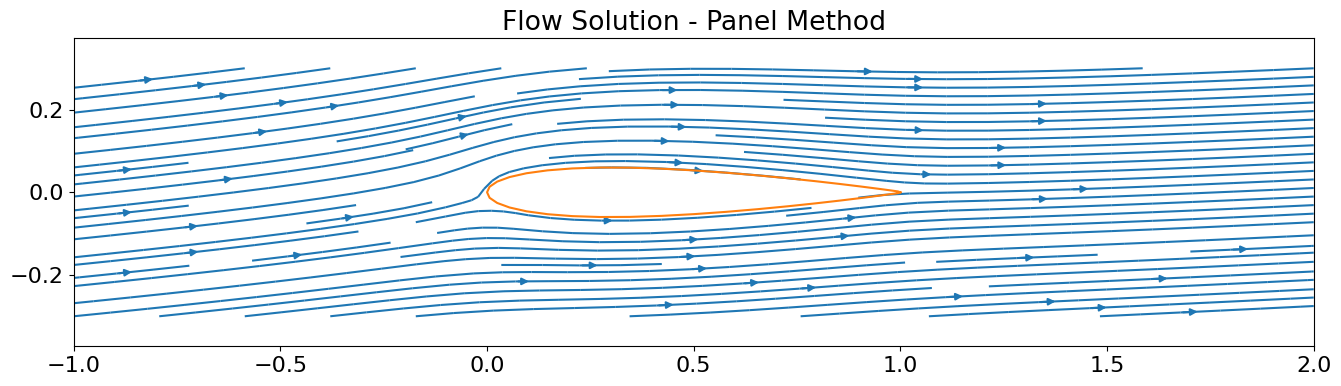

In [5]:
plt.figure(figsize=(16,4))
xg, yg = np.meshgrid(np.linspace(-1, 2, 40), np.linspace(-.3,.3, 40))
pfpm.plot_solution(sigma, xg, yg)
plt.title('Flow Solution - Panel Method')
plt.axis('equal');

print("C_L (PM):", pfpm.lift_coeffcient(sigma))

Using the adjoint technique we have seen in today's lecture, we can now perform an optimisation of the airfoil that optimises its shape in order to maximize its lift force. 

This optimisation will be based on a functional

$$
  f(\vsig, \vec x) = -\text{lift}(\vsig, \vec x) + \text{penalty}(Q(\vec x))
$$

where $\text{lift}(\vsig, \vec x)$ is the function that computes the lift based on the solution $\vsig$ and the shape of airfoil $\vec x$. We also have a penalty term $\text{penalty}(Q(\vec x))$ where $Q(\vec x)$ is the shape factor that we have implemented in tutorial L9:

$$
  Q(\vec x) = \frac l{\sqrt{A}}
$$

which has a minimum when the airfoil has the shape of an ellipse with a user-specified width/height aspect ratio. The penalty term rapidly increases as $\vec Q(\vec x)$ reaches an, again user-specified, maximum $Q_{\text{max}}$ to avoid the shape of the airfoil to deviate too much. More details about the exact form of the penalty term ...

As we minimize $f$, we maximize the lift of the airfoil while keeping its shape somewhat under control. Since our model does not take drag into account, if we would only optimize for lift, we would obtain some crazy shapes with a large vertical extent.

The functional is implemented in `AirfoilFunctional` class (with some reasonable defaults for the user-specified parameters) in the `airfoil_functional.py` python module that comes with this tutorial. It also implements the derivatives 

$$
  \frac{\partial f(\vsig, \vec x)}{\partial \vsig} \quad\text{ and }
    \frac{\partial f(\vsig, \vec x)}{\partial \vec x} \quad\text{ and }
$$

that we will need. It relies on the `grad_shape_factor` function we derived and tested in lecture 9 (the solution has been copied into this module).

In [6]:
from airfoil_functional import AirfoilFunctional
# partial derivatives of f
af = AirfoilFunctional()

# evaluate functional for given sigma and x:
print("Functional value:", af.f(sigma,x))

# evaluate the derivatives:
dfds = af.grad_sigma_f(sigma, x)
dfdx = af.grad_x_f(sigma, x)

C_L, Q, penalty, f(sigma, x) 0.5063064843150035 4.254208081494124 45.52291155313214 45.016605068817135
Functional value: 45.016605068817135


The panel method that computes our $\vsig$-values can be described as a PDE constraint 

$$
  g(\vsig, \vec x)=\mat A(\vec x)\vsig - \vec b(\vec x) = 0
$$

(see above how to obtain $\mat A$ and $\vec b$), 
and we also need its derivative:

$$
  \frac{\partial g(\vsig, \vec x)}{\partial\vec x} = \frac{\partial \mat A(\vec x)\vsig}{\partial\vec x} -
  \frac{\partial \vec b(\vec x)}{\partial\vec x}
$$

The latter has been implemented in the `panel_method_derivatives.py` module:

In [7]:
from panel_method_derivatives import panel_method_x_derivative
# partial derivatives of g
dgdx = panel_method_x_derivative(sigma, x, u_inf, alpha)

1. The shape of the airfoil are the parameters we want to optimize ($\vec m$ in the lecture), and $\vsig$ the solution of the PDE ($\vec u$) in the lecture. In the lecture we saw how we can formulate a reduced optimisation problem by defining a reduced functional:

$$
  \hat f(\vec x) = f(\vsig(\vec x), \vec x)
$$

where $\vsig(\vec x)$ is in this case the solution to

$$
  \mat A(\vec x)\vsig - \vec b(\vec x)
$$

Implement a function `fhat` that takes a vector $\vec x$ and returns the solution $\vsig$. Note that for every new vector  $\vec x$ you need to create a new `PotentialFlowMethod` object `pf`. You can reuse the `af` `AirfoilFunctional` object as it stays the same.

### Solution <a class="tocSkip"/></a>
We simply repeat the steps from above.

In [8]:
def fhat(x):
    pfpm = PotentialFlowPanelMethod(x, u_inf, alpha)

    A, b = pfpm.assemble()
    sigma = sl.solve(A, b)
        
    return af.f(sigma, x)

2. In today's lecture we have seen how the derivative of the reduced functional can be calculated in three steps. For convenience we repeat these here expressed in terms of $\vec x$ and $\vsig$:

i. For a given $\vec x$ compute $\vsig(\vec x)$.

ii. Using $\vec x$ and $\vsig$ solve the adjoint equation for $\vlam$:

$$
    \left(\frac{\partial g(\vsig, \vec x)}{\partial \vsig}\right)^T
  \vlam = \left(\frac{\partial f(\vsig, \vec x)}{\partial \vsig}\right)^T
$$

Note that since $g(\vsig, \vec x)=\mat A\vsig - \vec b$ is linear, this becomes simply

$$
    \mat A^T \vlam = \left(\frac{\partial f(\vsig, \vec x)}{\partial \vsig}\right)^T
$$

The right-hand side of this equation is given by the `grad_sigma_f` method of `af`.

iii. Assemble the derivative:

$$
  \frac{d\hat f(\vec x)}{d\vec x} = \frac{\partial f(\vsig, \vec x)}{\partial \vec x} - \vlam\cdot \frac{\partial g(\vsig, \vec x)}{\partial \vec x}
$$

The first term is given by the `grad_x_f` method of `af`. For the second term we use `panel_method_x_derivative`. **Hint:** for the dot-product you should not use `np.dot`. In our implementation $\vlam$ is a $n+1$-vector, the $\vec x$ positions are a $n+1\times 2$-vector, and $\partial g/\partial\vec x$ is $n+1\times n+1\times 2$. We should be summing over the index of $\vlam$ together with the *first* index of $\partial g/\partial\vec x$ (which correspond to the $n+1$ equations in $g$), however `np.dot` would contract over the second index of $\partial g/\partial\vec x$. Instead you may use `np.tensordot` in the following way:
```python
    # assume lam is a n+1 array
    dgdx = panel_method_x_deriviate(sigma, x, u_inf, alpha)  # returns n+1 x n+1 x 2 array
    lambda_dot_dgdx = np.tensordot(lam, dgdx, ((0,), (0,)))
```

Implement a function `grad_fhat` that performs these three steps and return the gradient $\frac{d\hat f(\vec x)}{d\vec x}$.

### Solution <a class="tocSkip"/></a>
See the function below:

In [9]:
def grad_fhat(x):
    # step 1
    pfpm = PotentialFlowPanelMethod(x, u_inf, alpha)

    A, b = pfpm.assemble()
    sigma = sl.solve(A, b)

    # step 2
    dfds = af.grad_sigma_f(sigma, x)
    lam = sl.solve(A.T, dfds)

    # step 3
    dfdx = af.grad_x_f(sigma, x)
    dgdx = panel_method_x_derivative(sigma, x, u_inf, alpha)
    lambda_dot_dgdx = np.tensordot(lam, dgdx, ((0,), (0,)))

    return dfdx - lambda_dot_dgdx

3. In lecture notebook 9 we learned about the importance of testing your gradient functions. Import the `taylor_test` from the `utility.py` module and run a Taylor test on `grad_fhat`. Go back to question 2 if you are not passing the test!

C_L, Q, penalty, f(sigma, x) 0.4961095106948272 5.8733382470024305 207.43592810396285 206.93981859326803
C_L, Q, penalty, f(sigma, x) 0.5063064843150019 4.254208081494124 45.52291155313214 45.016605068817135
C_L, Q, penalty, f(sigma, x) 0.5696545178458955 4.6586629131885005 85.96839472256981 85.39874020472392
C_L, Q, penalty, f(sigma, x) 0.5063064843150019 4.254208081494124 45.52291155313214 45.016605068817135
C_L, Q, penalty, f(sigma, x) 0.552859395935406 4.3466209088704755 54.76419429076733 54.21133489483192
C_L, Q, penalty, f(sigma, x) 0.5063064843150019 4.254208081494124 45.52291155313214 45.016605068817135
C_L, Q, penalty, f(sigma, x) 0.5329637915480343 4.276961544851269 47.79825788884668 47.26529409729864
C_L, Q, penalty, f(sigma, x) 0.5063064843150019 4.254208081494124 45.52291155313214 45.016605068817135
C_L, Q, penalty, f(sigma, x) 0.5207378392969184 4.260158386616069 46.11794206532664 45.59720422602972
C_L, Q, penalty, f(sigma, x) 0.5063064843150019 4.254208081494124 45.52291

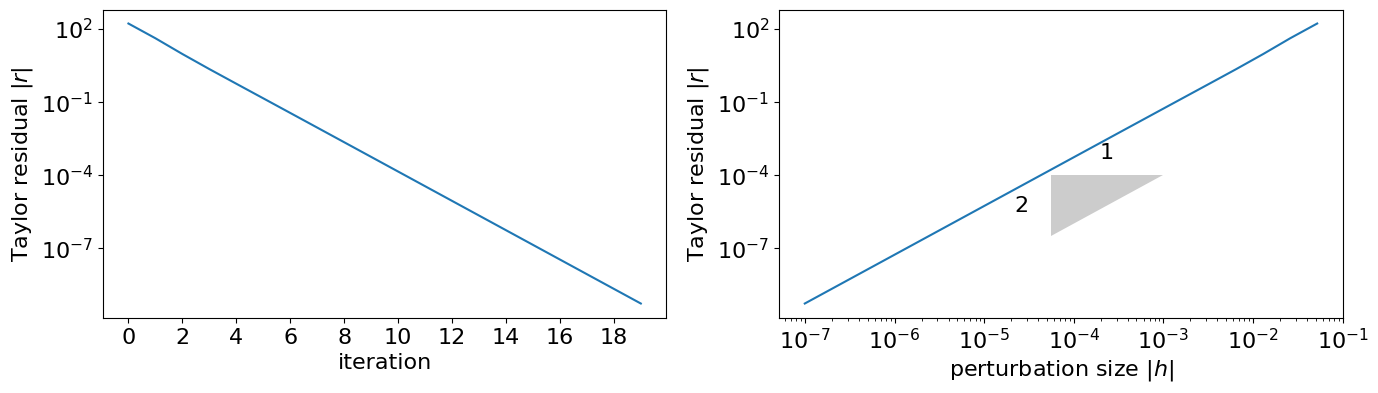

In [10]:
from utility import taylor_test
# you can also start from a different polygon by using e.g. regular_polygon:
x0 = np.loadtxt('naca0012.dat')
# a random perturbation of +- 0.01
dx = (np.random.random(x0.shape) - 0.5) * 0.02
taylor_test(fhat, grad_fhat, x0, dx)

### Solution <a class="tocSkip"/></a>
This is what I get:

C_L, Q, penalty, f(sigma, x) 0.7644381204367168 5.968126204054633 216.91472380918307 216.15028568874635
C_L, Q, penalty, f(sigma, x) 0.5063064843150019 4.254208081494124 45.52291155313214 45.016605068817135
C_L, Q, penalty, f(sigma, x) 0.3687492838207708 4.7404621333319765 94.14831673691742 93.77956745309665
C_L, Q, penalty, f(sigma, x) 0.5063064843150019 4.254208081494124 45.52291155313214 45.016605068817135
C_L, Q, penalty, f(sigma, x) 0.5771216239807192 4.371707942949072 57.27289769862702 56.695776074646304
C_L, Q, penalty, f(sigma, x) 0.5063064843150019 4.254208081494124 45.52291155313214 45.016605068817135
C_L, Q, penalty, f(sigma, x) 0.5206637257813554 4.282094086344228 48.31151203814254 47.790848312361184
C_L, Q, penalty, f(sigma, x) 0.5063064843150019 4.254208081494124 45.52291155313214 45.016605068817135
C_L, Q, penalty, f(sigma, x) 0.511022808976907 4.263738936755784 46.47599707929818 45.96497427032128
C_L, Q, penalty, f(sigma, x) 0.5063064843150019 4.254208081494124 45.52291

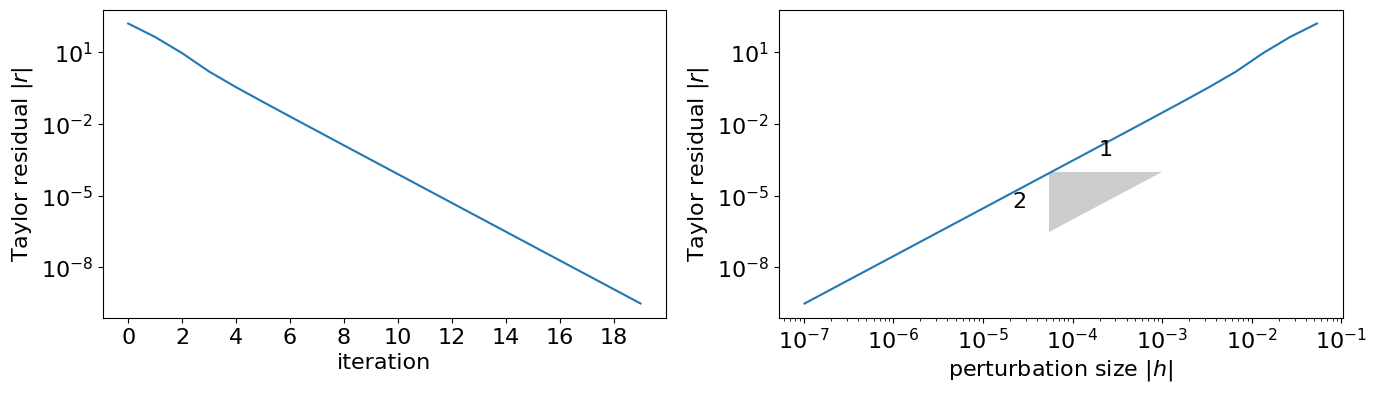

In [11]:
from utility import taylor_test
# you can also start from a different polygon by using e.g. regular_polygon:
x0 = np.loadtxt('naca0012.dat')
# a random perturbation of +- 0.01
dx = (np.random.random(x0.shape) - 0.5) * 0.02
taylor_test(fhat, grad_fhat, x0, dx)

4. Now we have all the ingredients for the optimisation! You can use the `ShapeOptimisationProblem` we used in tutorial L9 which wraps [scipy's minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). This is to ensure that the vector $\vec x$ of locations, which we store as a $n+1\times 2$ array, gets reshaped into a flat $2(n+1)$ array that scipy's minimize expects. Of course you will probably need more than the 10 maximum iteration that are specified below, but you can start with this to test that everything works:

In [12]:
from utility import ShapeOptimisationProblem
x0 = np.loadtxt('naca0012.dat')
so = ShapeOptimisationProblem(x0, fhat, grad_fhat)
result = so.minimize(method='BFGS', tol=0.01, options={'maxiter': 10})

C_L, Q, penalty, f(sigma, x) 0.5063064843150035 4.254208081494124 45.52291155313214 45.016605068817135
C_L, Q, penalty, f(sigma, x) -0.8622634281408731 113.9252835726174 11012.630460665461 11013.492724093601
C_L, Q, penalty, f(sigma, x) 0.712770184171012 10.972998715881031 717.4019749918228 716.6892048076518
C_L, Q, penalty, f(sigma, x) 0.5097397542370331 4.240333571159492 44.13546051966896 43.62572076543193
C_L, Q, penalty, f(sigma, x) 0.5104272835452821 4.216118282677353 41.713931671455114 41.20350438790983
C_L, Q, penalty, f(sigma, x) 0.5121163423889983 4.172705727275749 37.37267613129464 36.86055978890564
C_L, Q, penalty, f(sigma, x) 0.5158329870781467 4.123064325372785 32.40853594099828 31.892702953920132
C_L, Q, penalty, f(sigma, x) 0.5204470407293935 4.064227242833812 26.524827687101023 26.00438064637163
C_L, Q, penalty, f(sigma, x) 0.5256240947286213 4.075757725161425 27.67787591986232 27.1522518251337
C_L, Q, penalty, f(sigma, x) 0.523113120929952 4.021617180437007 22.26382144

Afterwards you can plot the shapes during the iterations, using:

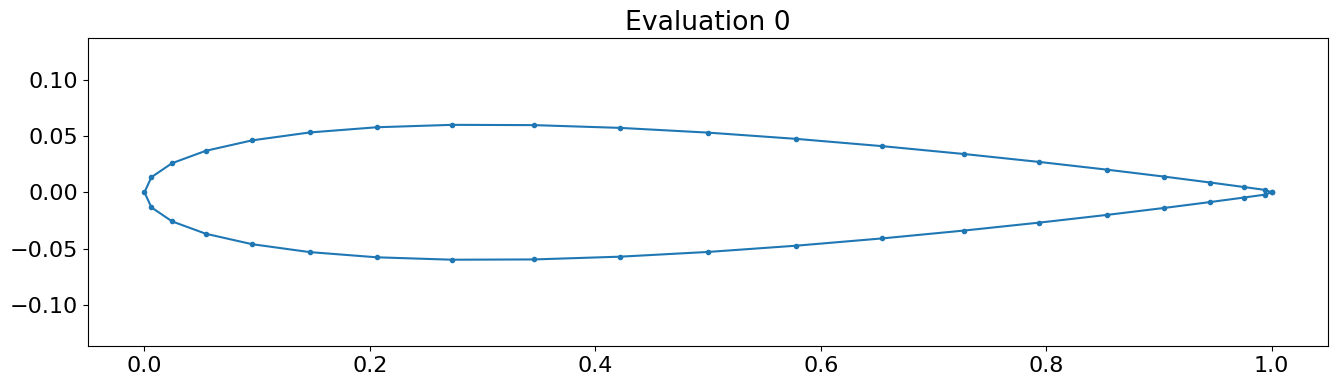

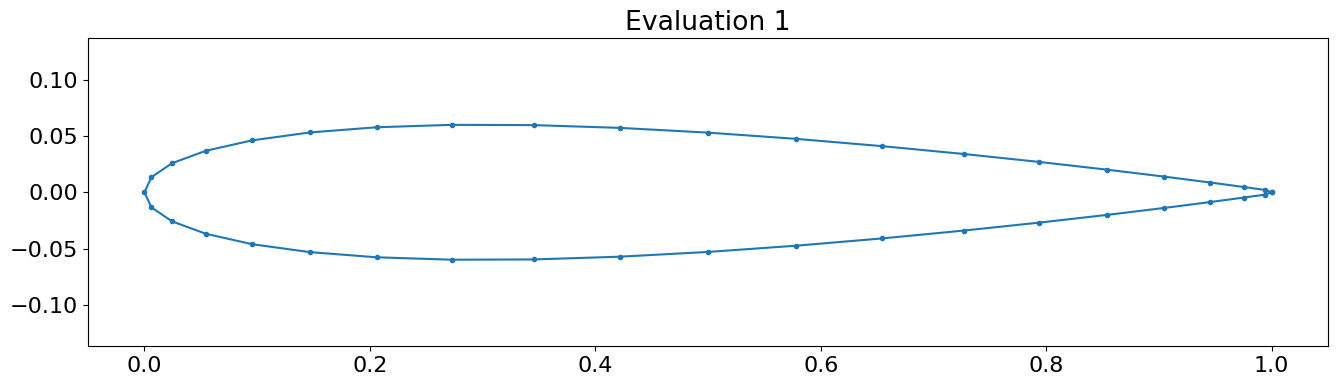

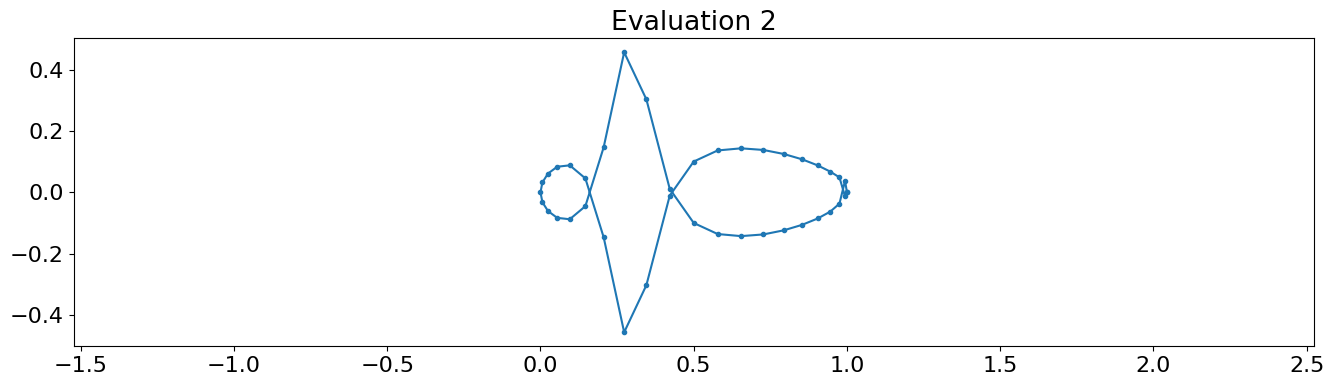

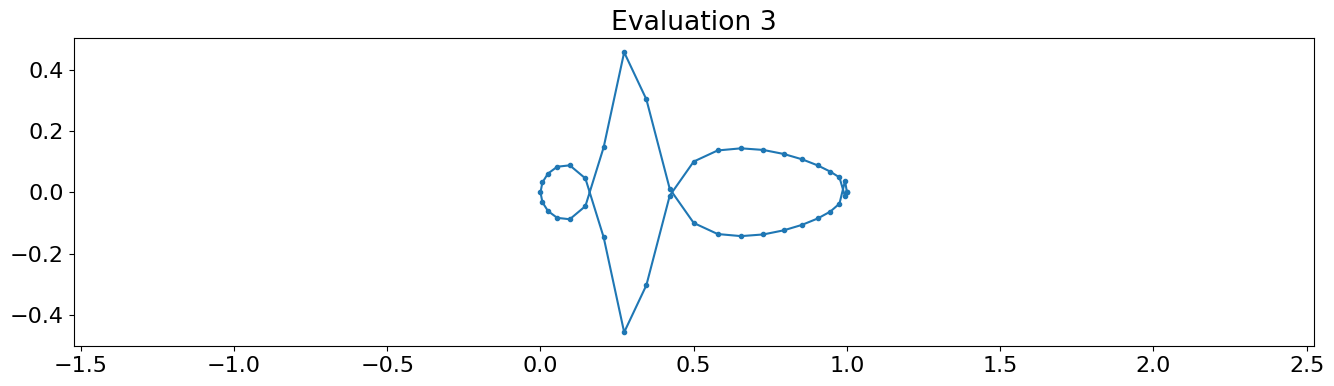

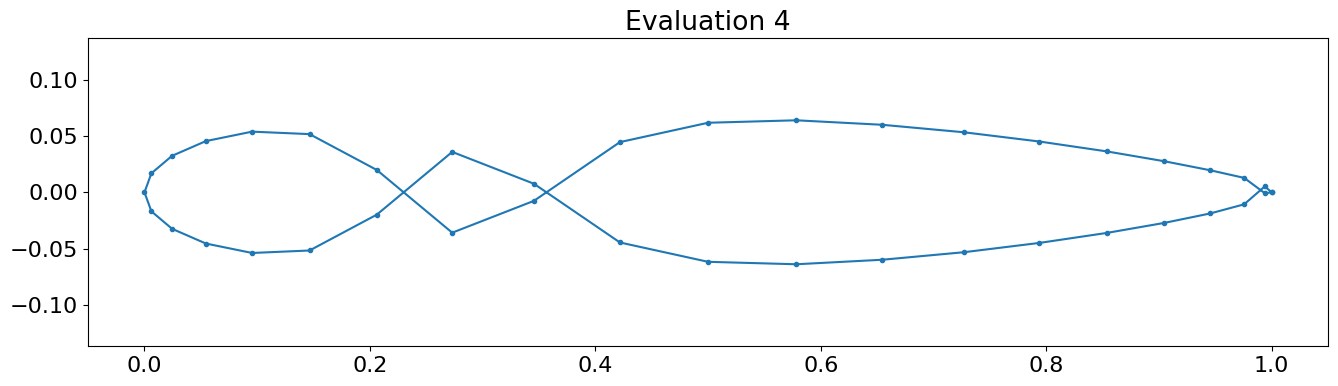

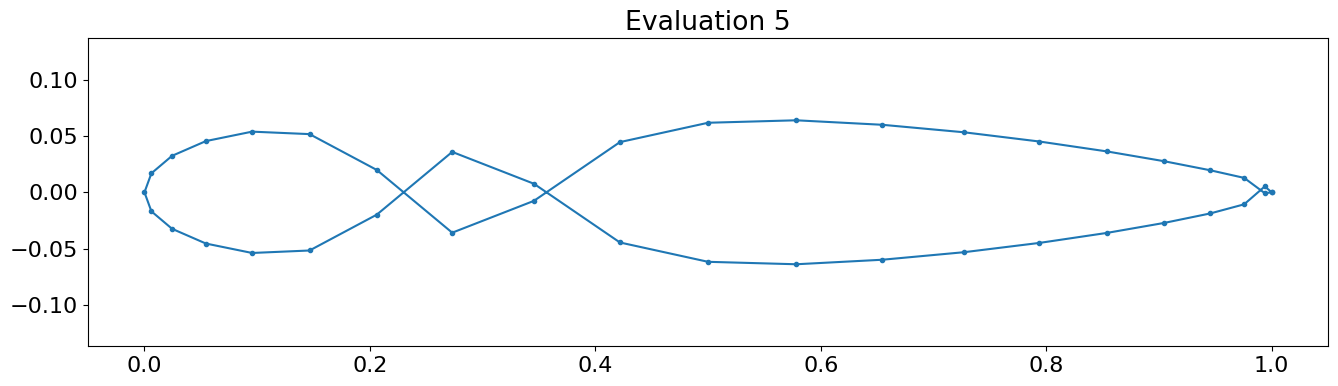

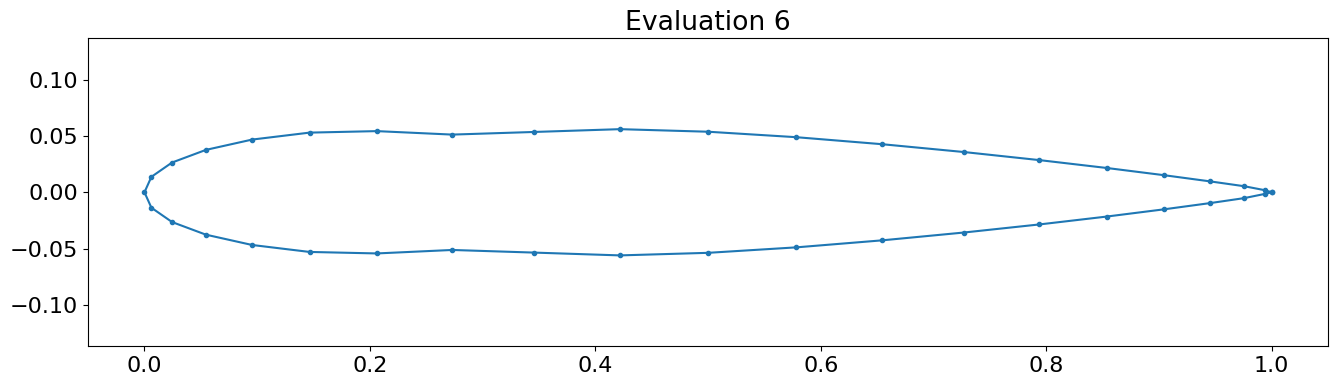

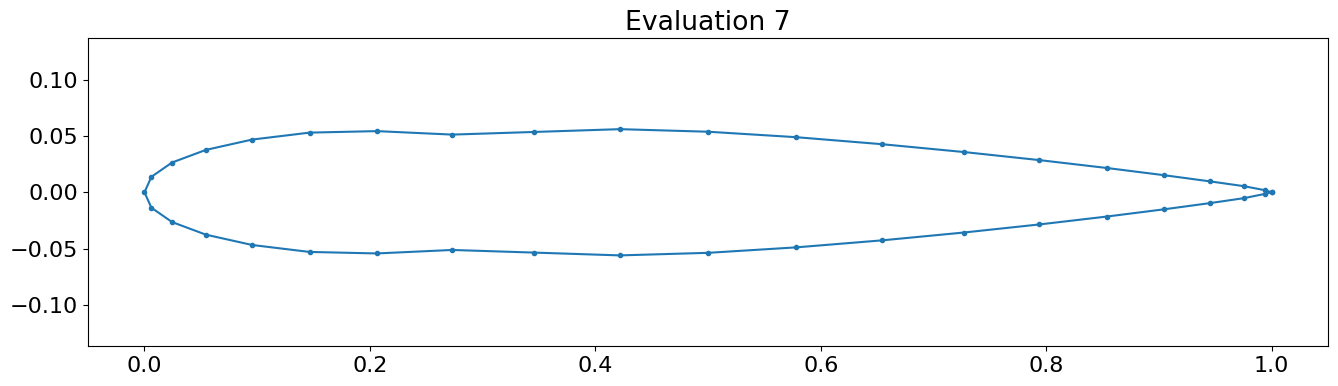

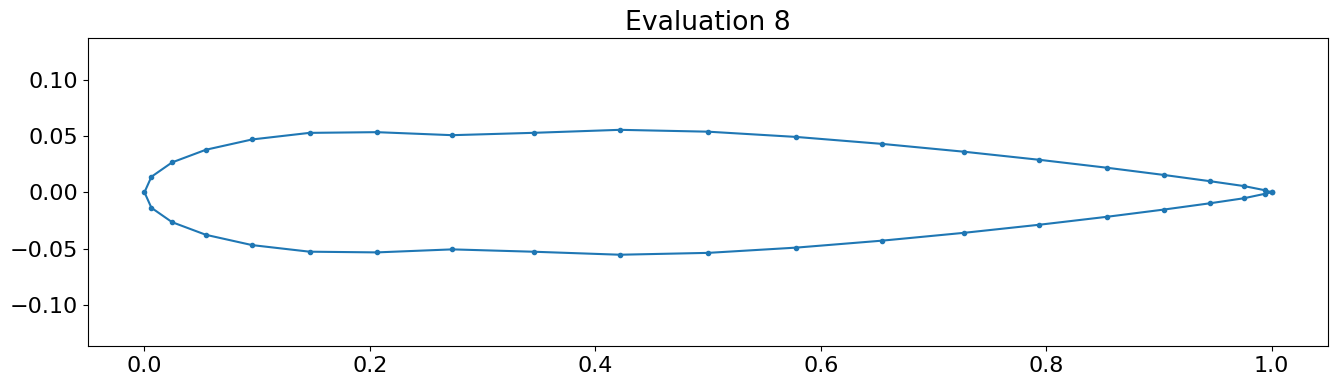

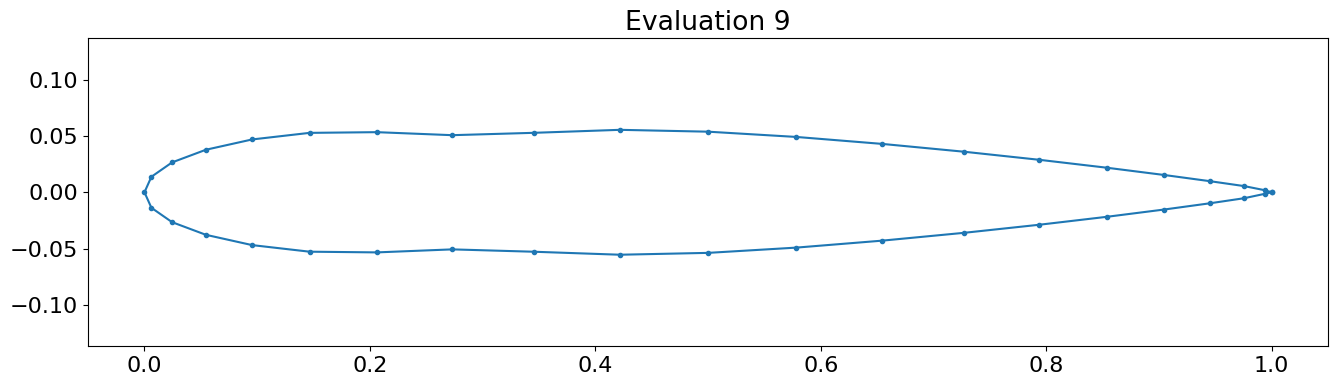

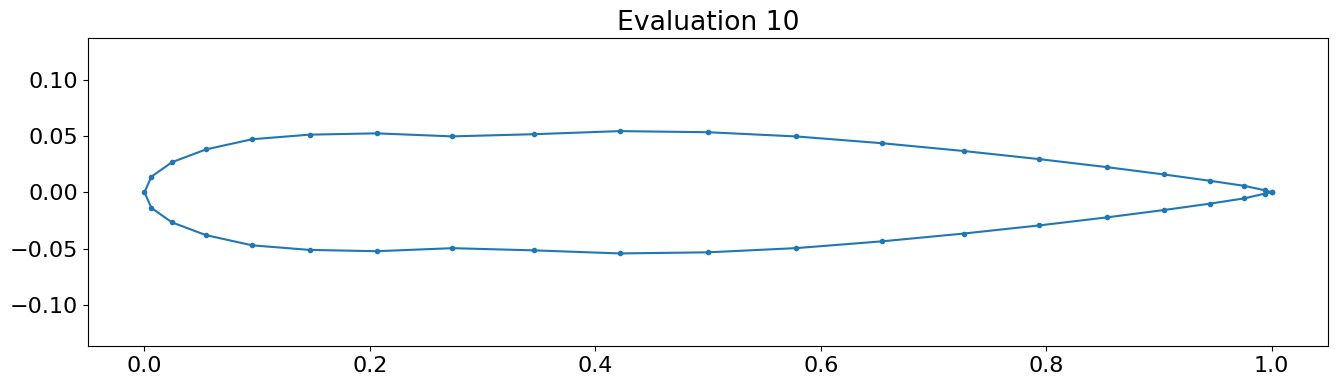

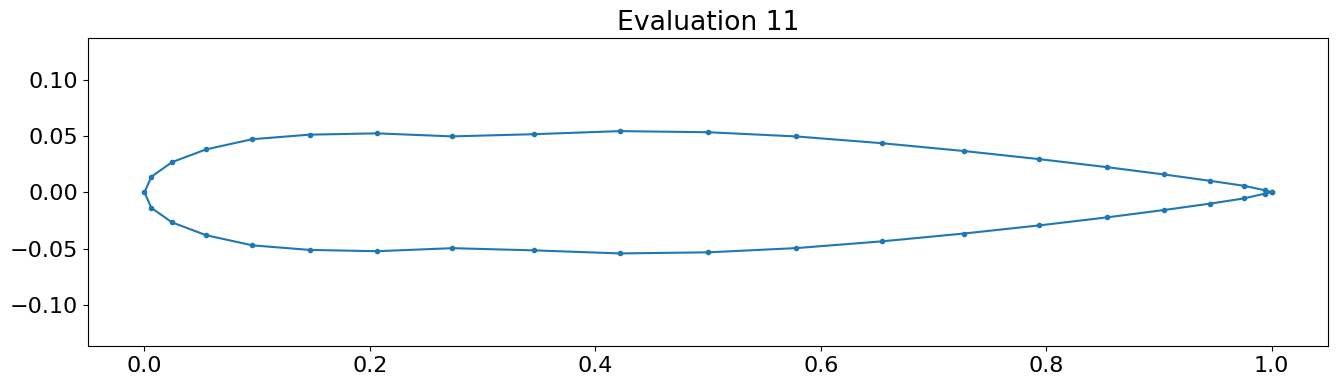

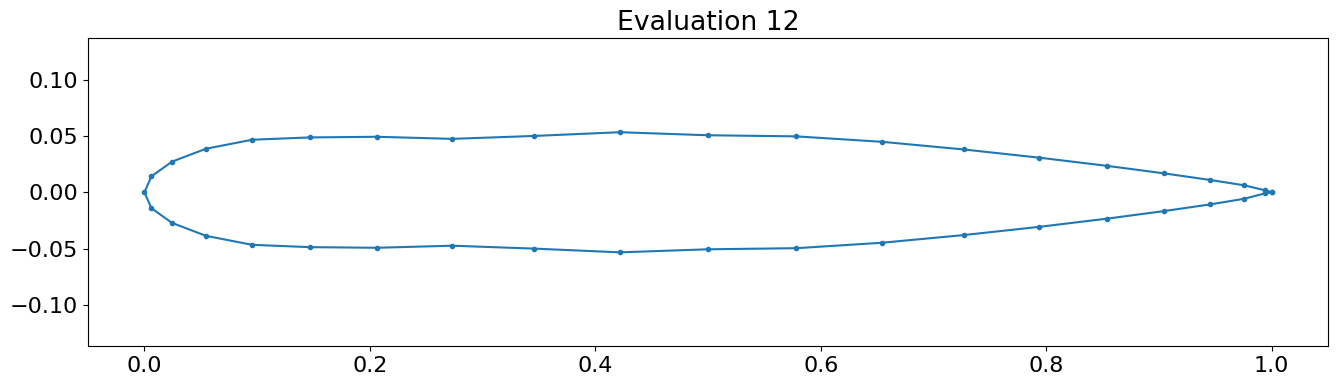

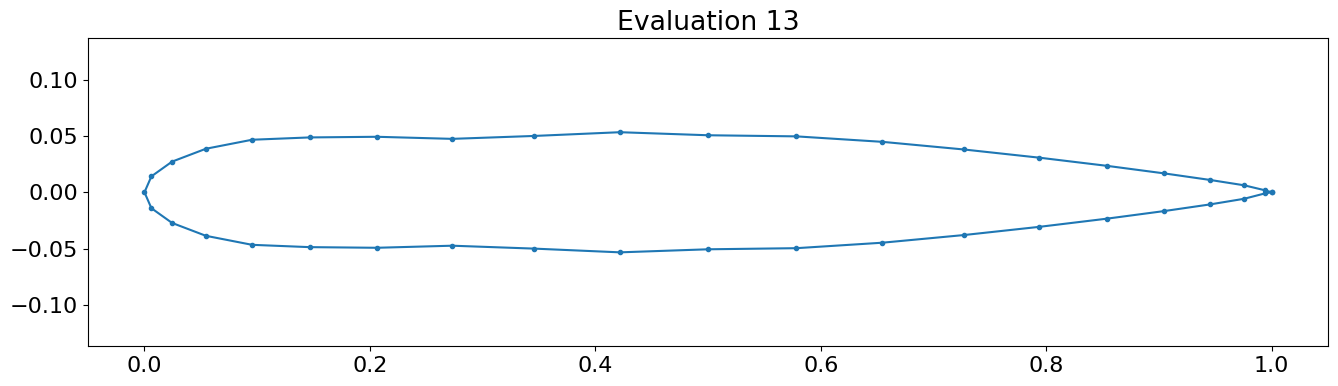

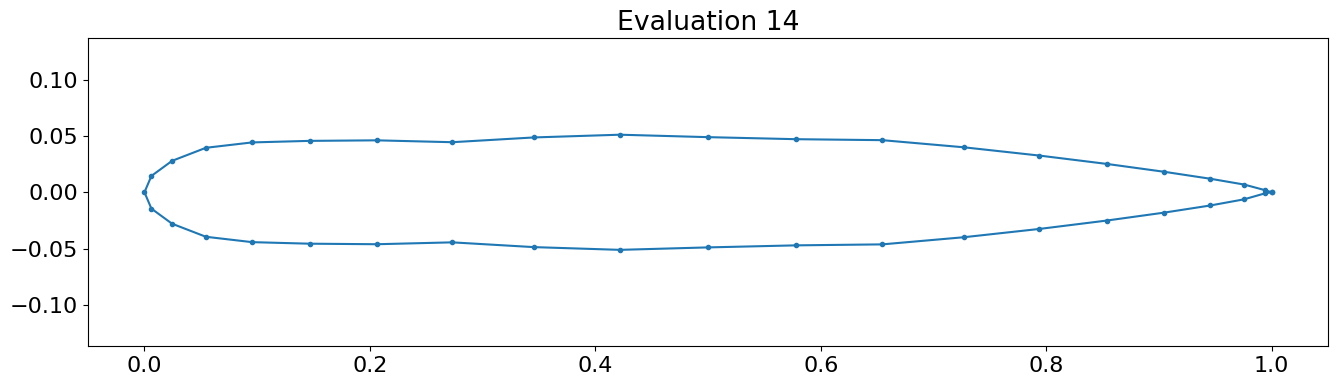

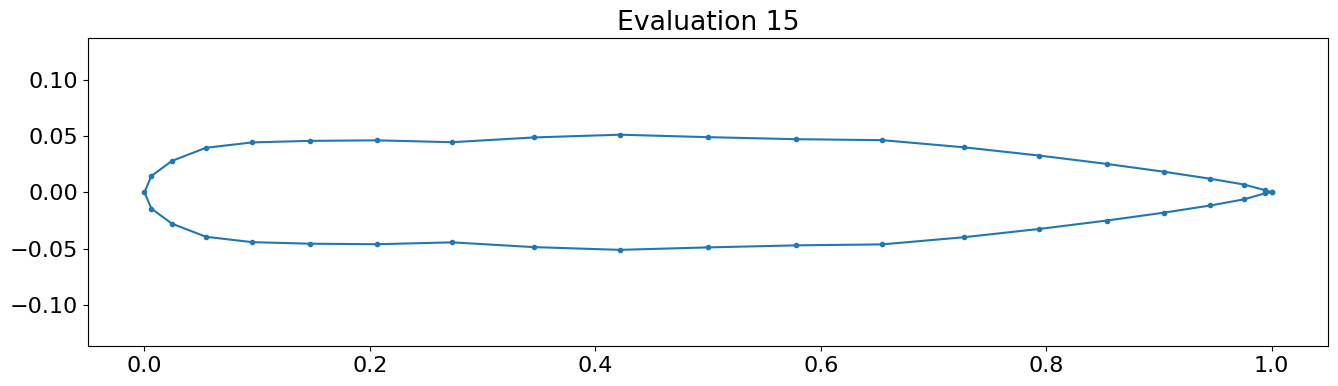

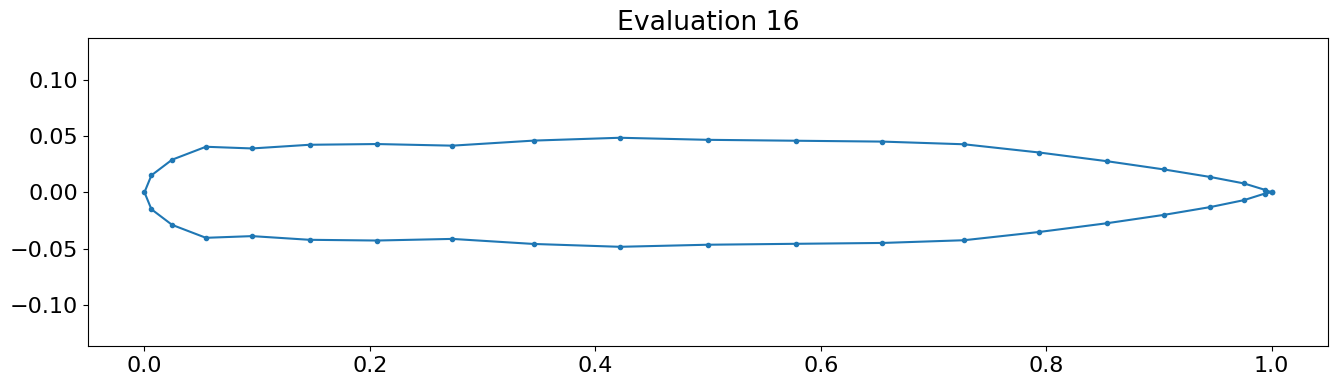

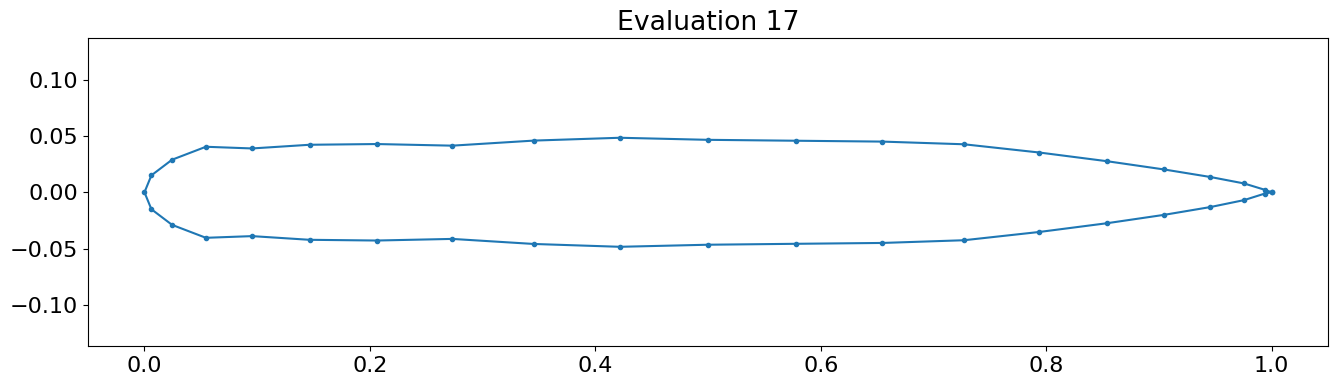

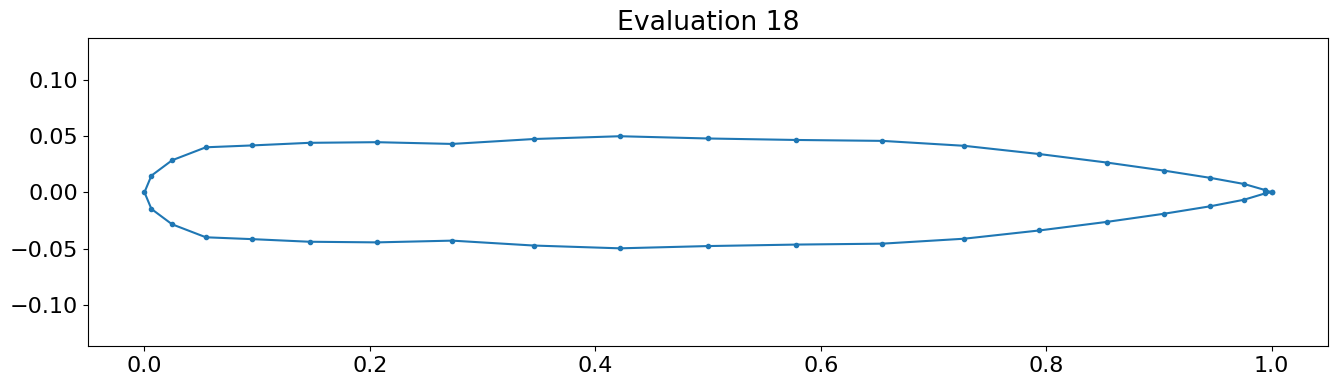

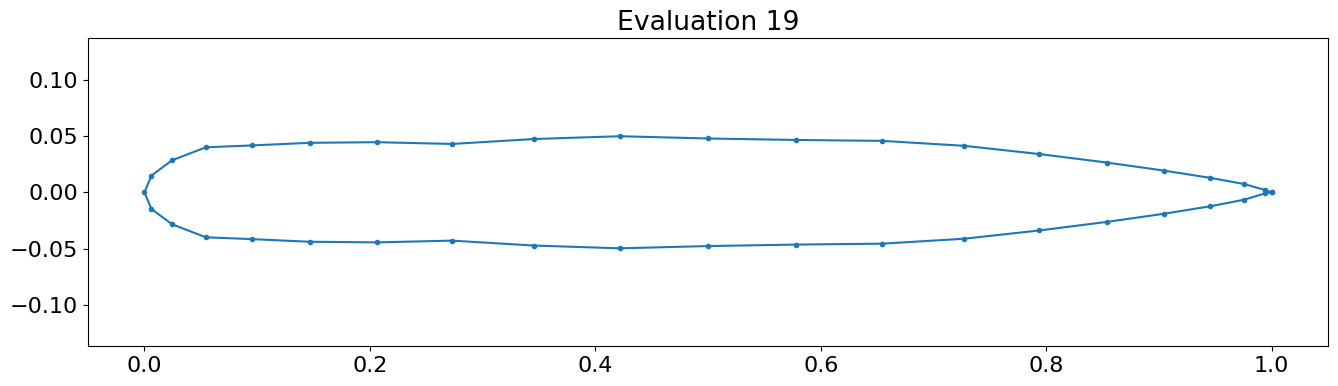

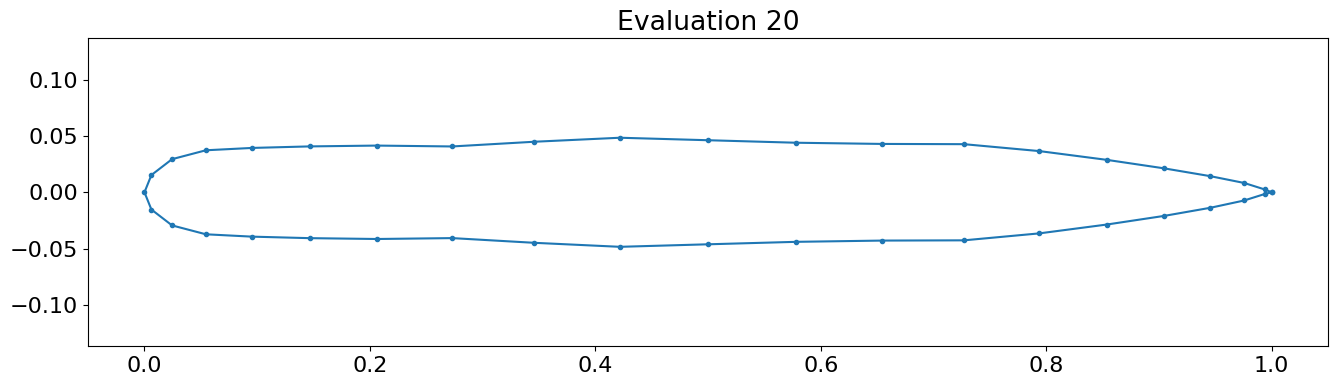

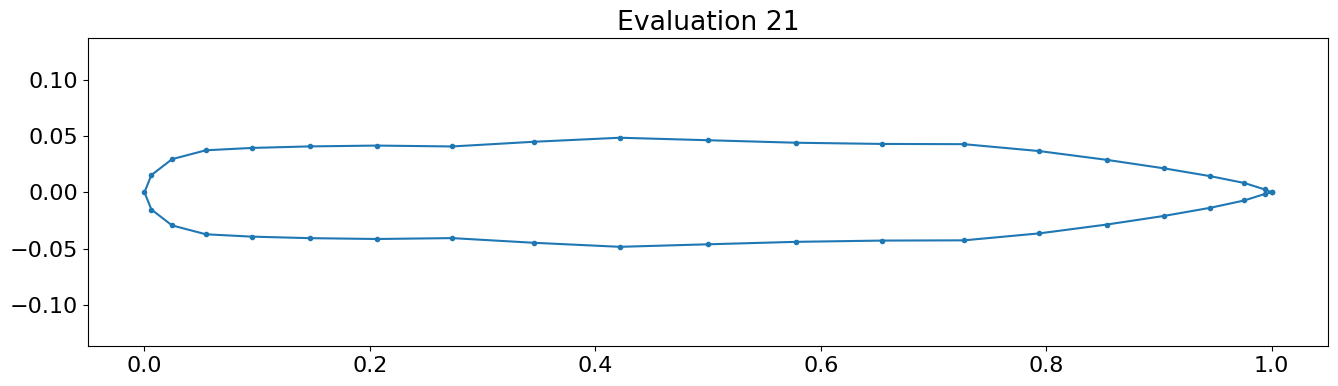

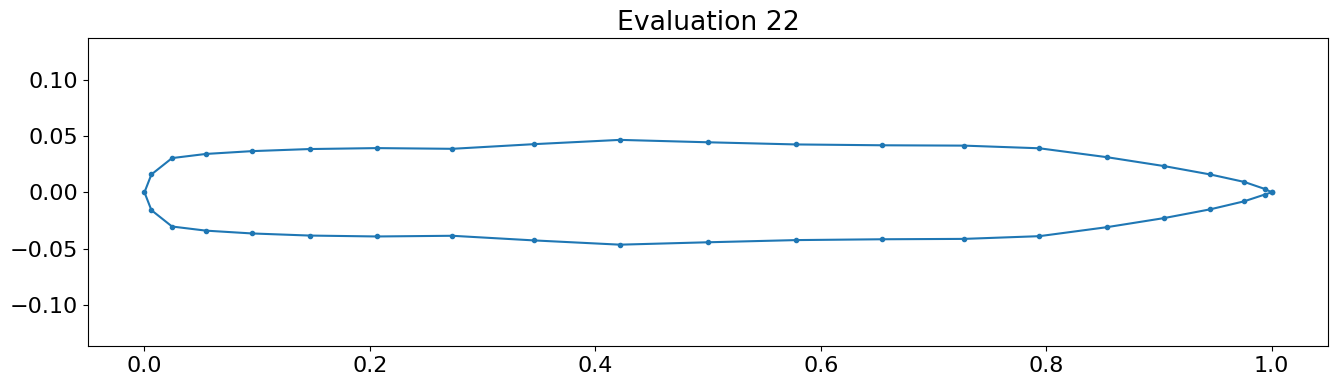

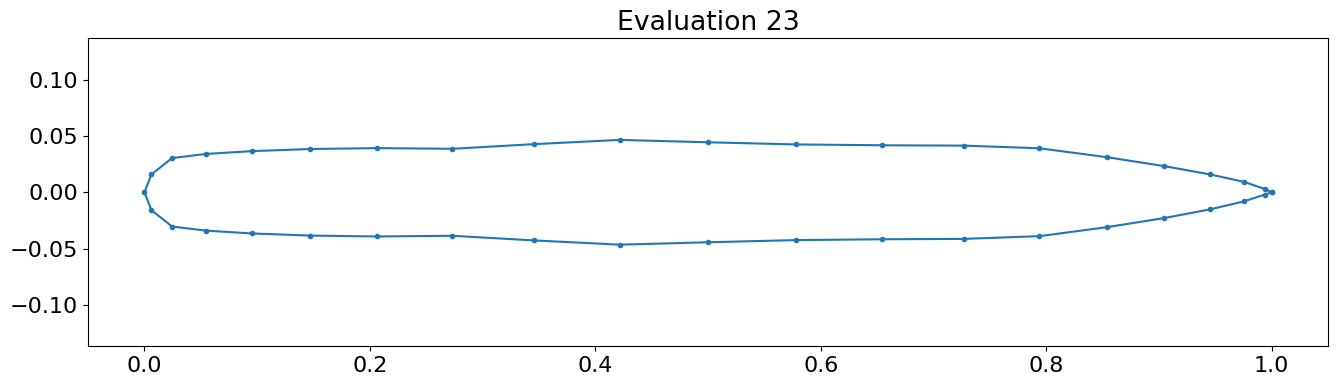

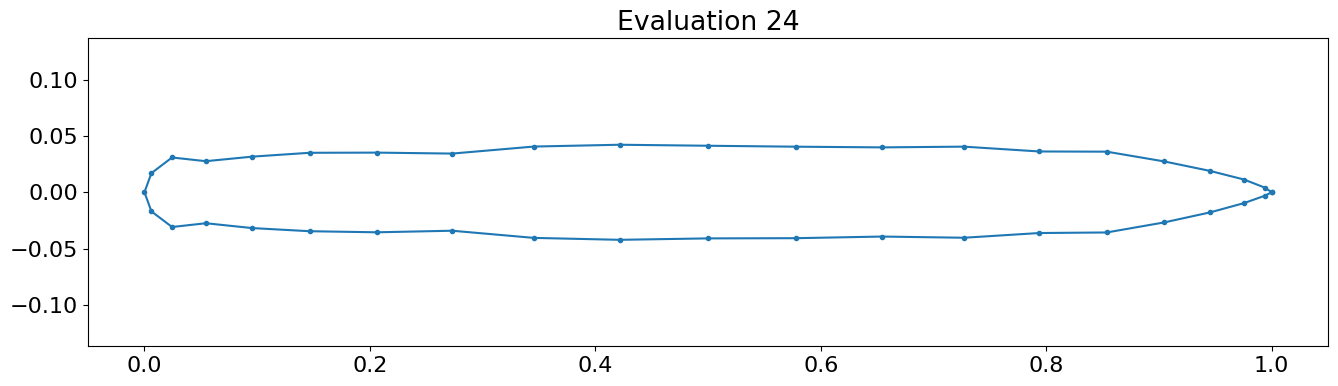

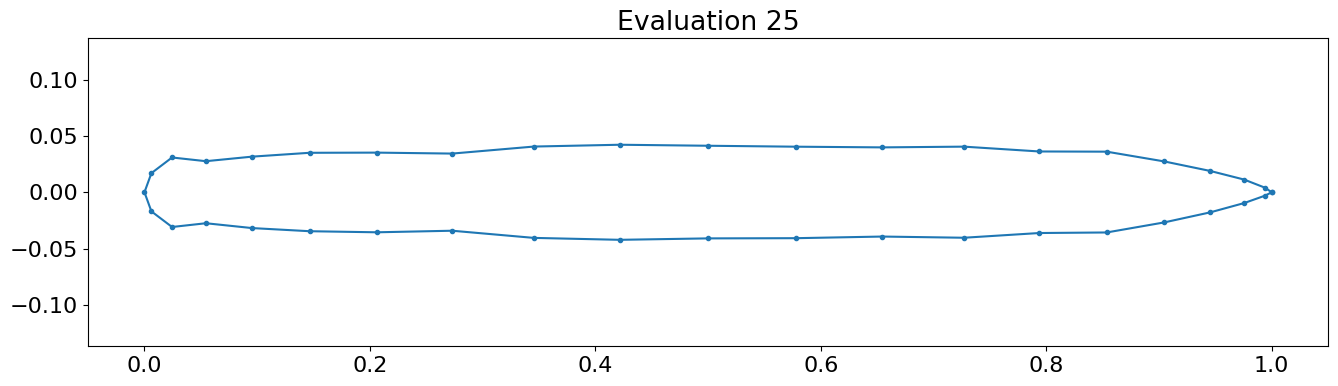

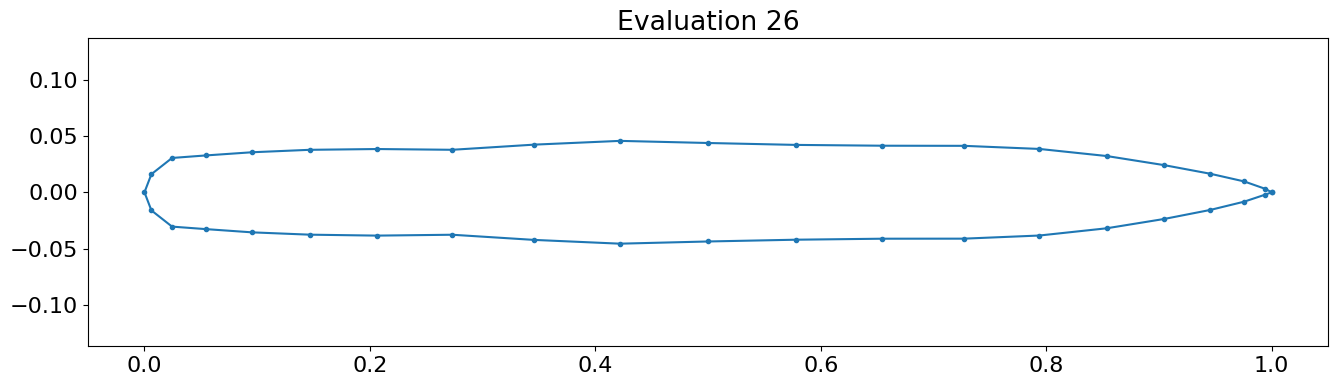

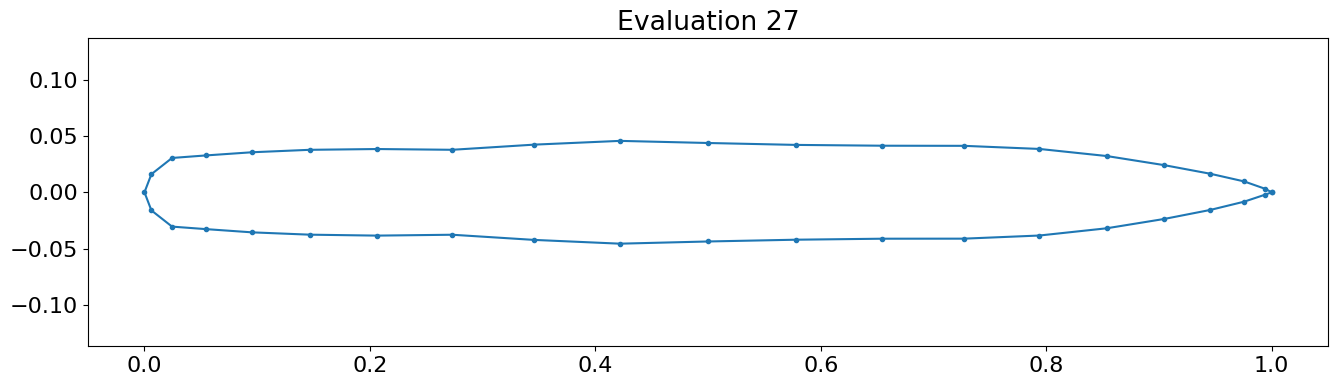

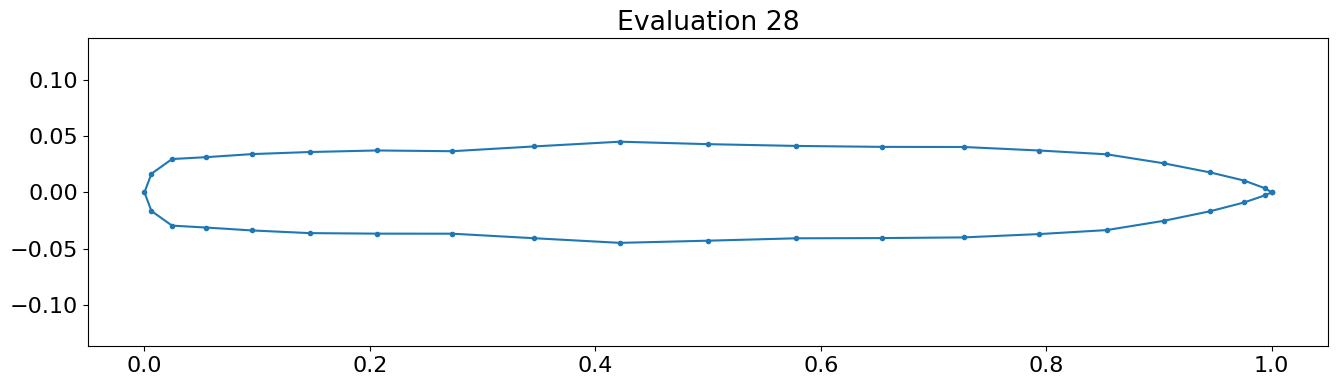

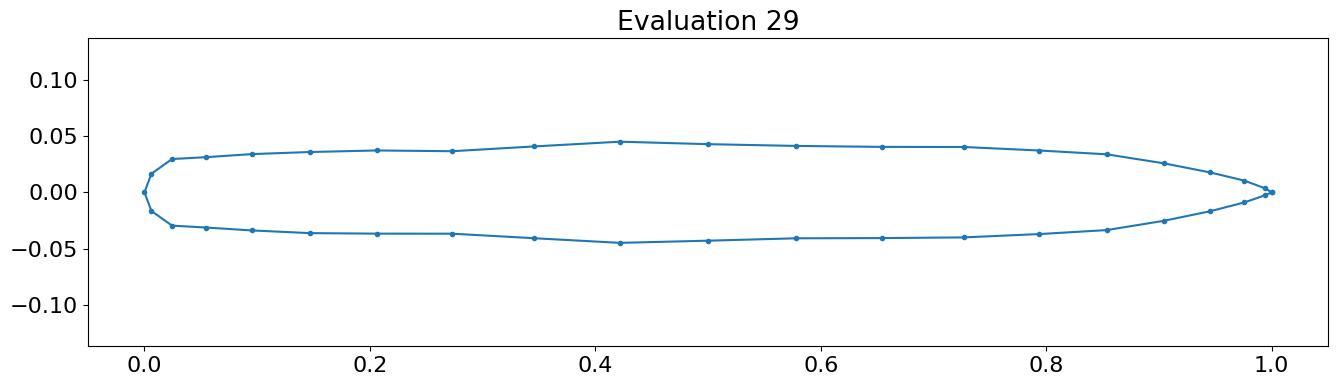

In [13]:
for i, x in enumerate(so.x_i[:]):
    plt.figure(figsize=(16,4))
    plt.plot(x[:,0], x[:,1], '.-')
    plt.axis('equal')
    plt.title('Evaluation {}'.format(i))
    plt.show()

Of course, you also want to check whether the lift coefficient has actually increased:

In [14]:
x = so.x  # this is the last iterate

# recompute sigma:
pfpm = PotentialFlowPanelMethod(x, u_inf, alpha)
A, b = pfpm.assemble()
sigma = sl.solve(A, b)


print(af.lift(sigma, x))

0.5358006232496157


### Solution <a class="tocSkip"></a>
My results:

In [15]:
from utility import ShapeOptimisationProblem
x0 = np.loadtxt('naca0012.dat')
so = ShapeOptimisationProblem(x0, fhat, grad_fhat)
result = so.minimize(method='BFGS', tol=0.01, options={'maxiter': 200})

C_L, Q, penalty, f(sigma, x) 0.5063064843150035 4.254208081494124 45.52291155313214 45.016605068817135
C_L, Q, penalty, f(sigma, x) -0.8622634281408731 113.9252835726174 11012.630460665461 11013.492724093601
C_L, Q, penalty, f(sigma, x) 0.712770184171012 10.972998715881031 717.4019749918228 716.6892048076518
C_L, Q, penalty, f(sigma, x) 0.5097397542370331 4.240333571159492 44.13546051966896 43.62572076543193
C_L, Q, penalty, f(sigma, x) 0.5104272835452821 4.216118282677353 41.713931671455114 41.20350438790983
C_L, Q, penalty, f(sigma, x) 0.5121163423889983 4.172705727275749 37.37267613129464 36.86055978890564
C_L, Q, penalty, f(sigma, x) 0.5158329870781467 4.123064325372785 32.40853594099828 31.892702953920132
C_L, Q, penalty, f(sigma, x) 0.5204470407293935 4.064227242833812 26.524827687101023 26.00438064637163
C_L, Q, penalty, f(sigma, x) 0.5256240947286213 4.075757725161425 27.67787591986232 27.1522518251337
C_L, Q, penalty, f(sigma, x) 0.523113120929952 4.021617180437007 22.26382144

C_L, Q, penalty, f(sigma, x) 1.483979761452243 3.7992252061781775 0.07162913600363162 -1.4123506254486113
C_L, Q, penalty, f(sigma, x) 1.5234753016429199 3.7993793765560953 0.073847860304718 -1.449627441338202
C_L, Q, penalty, f(sigma, x) 1.6086617038840663 3.801371467735924 0.2392501773121622 -1.369411526571904
C_L, Q, penalty, f(sigma, x) 1.5454982553963224 3.799634911251166 0.0791537008644691 -1.4663445545318532
C_L, Q, penalty, f(sigma, x) 1.587318147363612 3.800297581463031 0.13186155002288893 -1.455456597340723
C_L, Q, penalty, f(sigma, x) 1.5619478907499091 3.7998068137205903 0.08551855656256568 -1.4764293341873436
C_L, Q, penalty, f(sigma, x) 1.5805813121259418 3.799847474842147 0.08788181005996949 -1.4926995020659724
C_L, Q, penalty, f(sigma, x) 1.6007317760710706 3.7997628272879265 0.08346721939307798 -1.5172645566779928
C_L, Q, penalty, f(sigma, x) 1.6420909680049178 3.800602339327959 0.16233733651568963 -1.4797536314892281
C_L, Q, penalty, f(sigma, x) 1.6139114644316277 3.7

C_L, Q, penalty, f(sigma, x) 1.9650211393367032 3.795680574200568 0.05444632802358511 -1.910574811313118
C_L, Q, penalty, f(sigma, x) 1.9650194460770396 3.7956797517720084 0.054444424181937026 -1.9105750218951025
C_L, Q, penalty, f(sigma, x) 1.9650266339027662 3.7956827912510938 0.05445146208491912 -1.9105751718178472
C_L, Q, penalty, f(sigma, x) 1.9650366134820445 3.795687055382285 0.05446134402179118 -1.9105752694602534
C_L, Q, penalty, f(sigma, x) 1.965045783059038 3.7956909674677806 0.05447041870546521 -1.9105753643535728
C_L, Q, penalty, f(sigma, x) 1.9650519655602885 3.79569357895453 0.054476481037078854 -1.9105754845232097
C_L, Q, penalty, f(sigma, x) 1.9650496115943747 3.795692515990013 0.054474013017020935 -1.9105755985773538
C_L, Q, penalty, f(sigma, x) 1.9650401868269671 3.7956884261315547 0.05446452274830998 -1.910575664078657
C_L, Q, penalty, f(sigma, x) 1.9650321590266546 3.795684950744032 0.054456465394556244 -1.9105756936320983
C_L, Q, penalty, f(sigma, x) 1.96502677174

Checking we actually converged:

In [16]:
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.910575871273162
        x: [ 2.052e-02  6.766e-02 ... -8.103e-05 -1.382e-04]
      nit: 149
      jac: [ 4.590e-04  2.788e-03 ... -4.843e-03  3.080e-03]
 hess_inv: [[ 3.684e-03  8.493e-05 ... -4.861e-06 -1.969e-05]
            [ 8.493e-05  1.298e-04 ... -1.856e-05 -1.193e-06]
            ...
            [-4.861e-06 -1.856e-05 ...  1.549e-05  5.536e-06]
            [-1.969e-05 -1.193e-06 ...  5.536e-06  6.839e-06]]
     nfev: 177
     njev: 177

Plotting every 10th iteration:

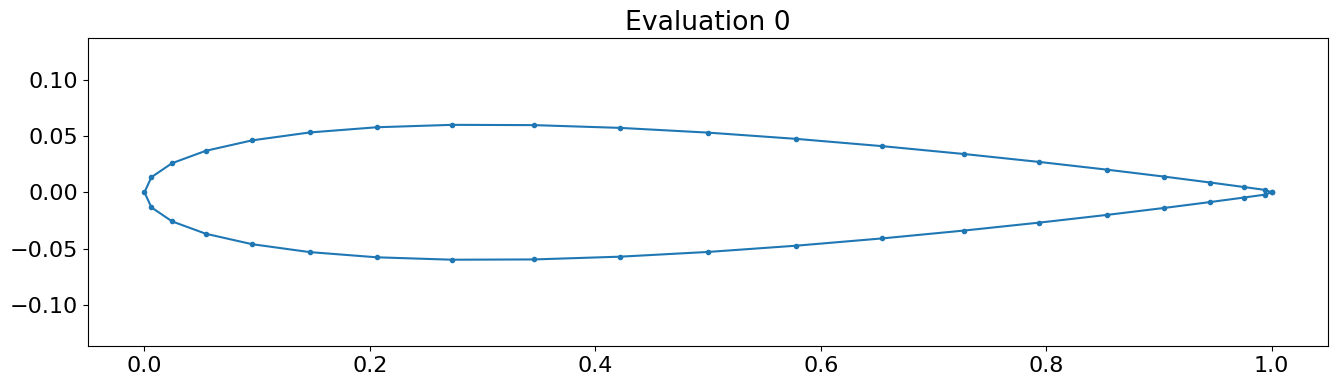

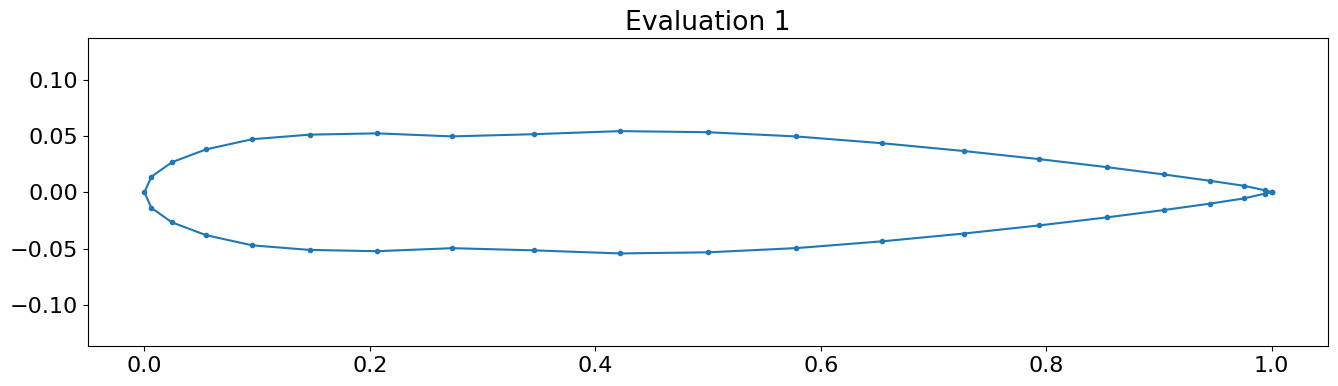

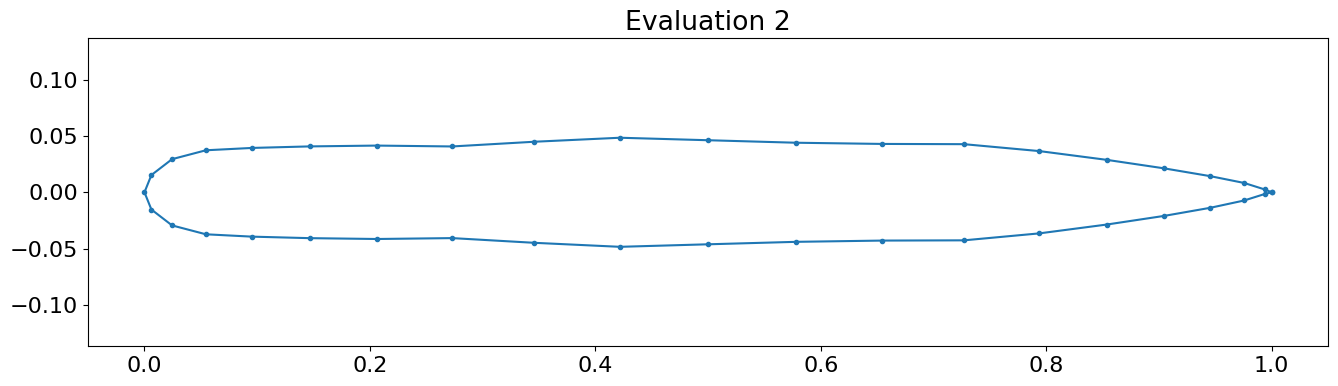

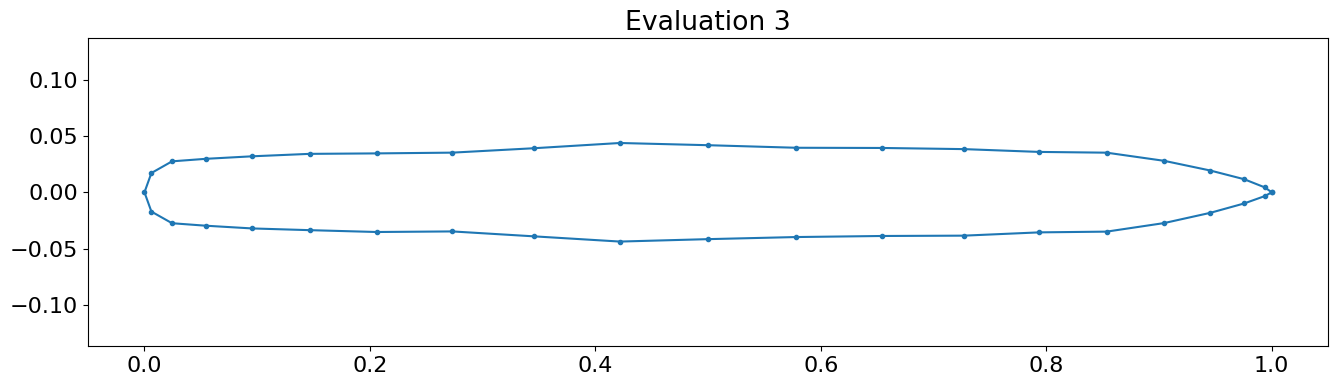

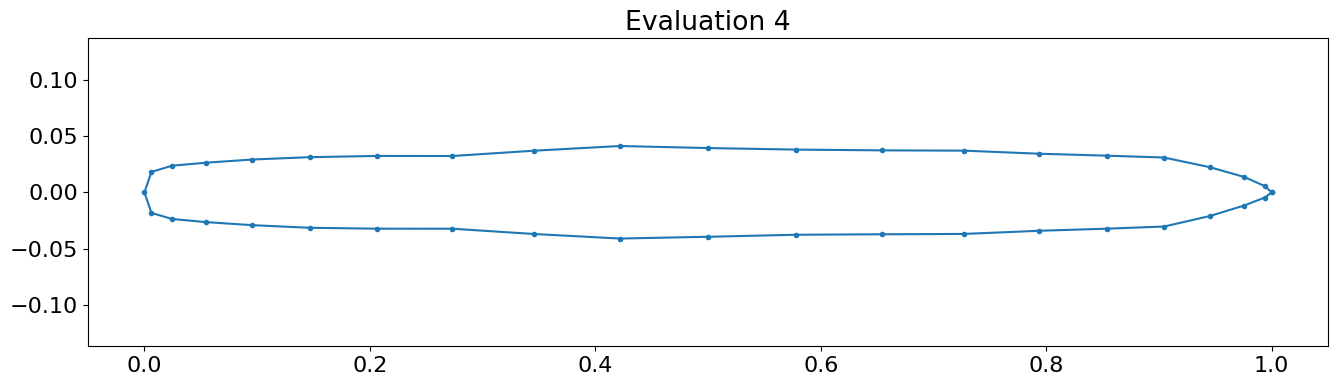

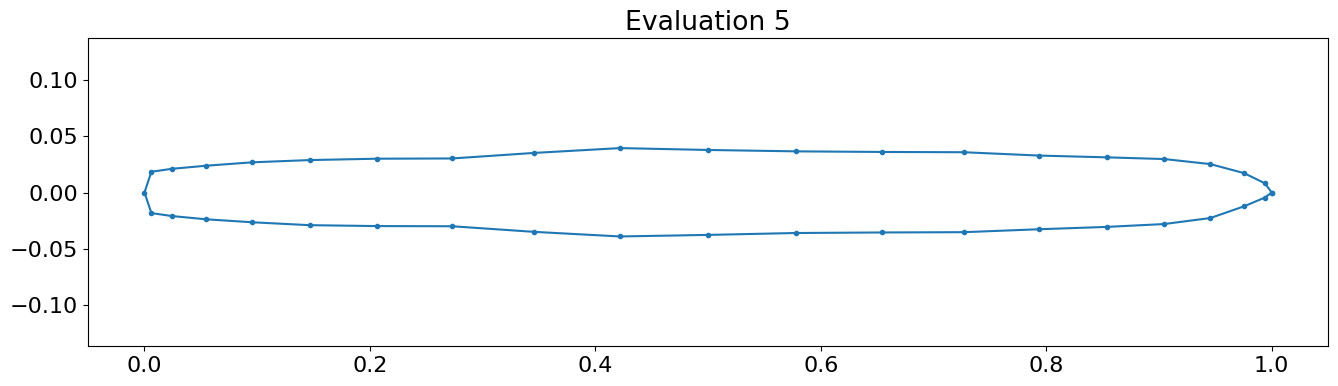

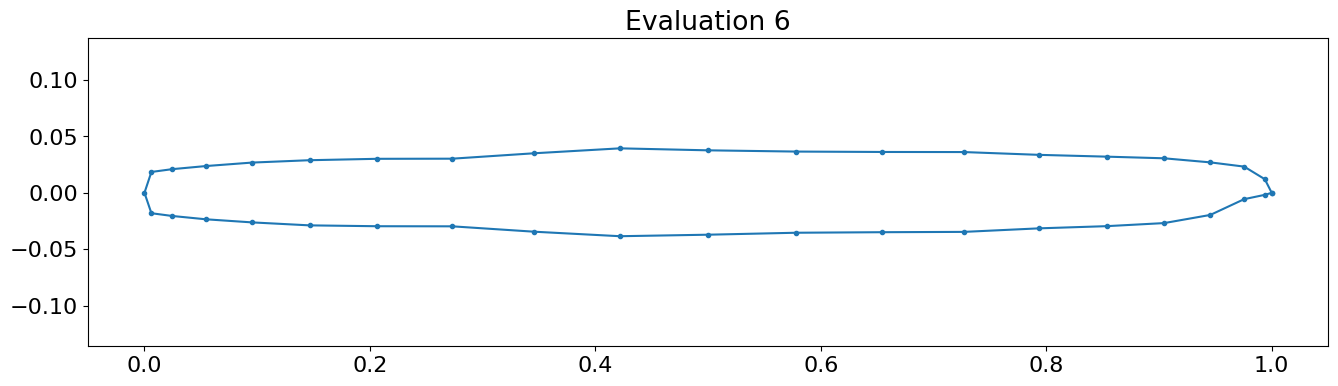

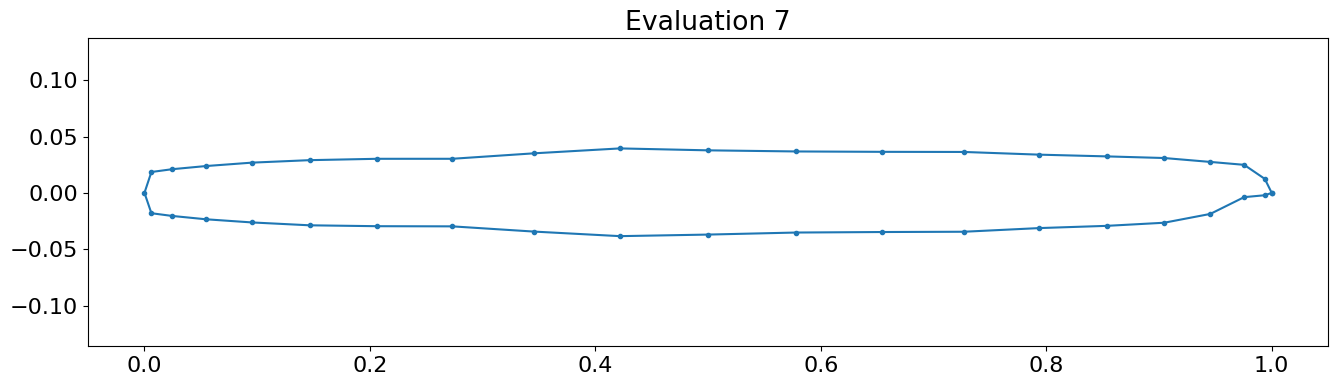

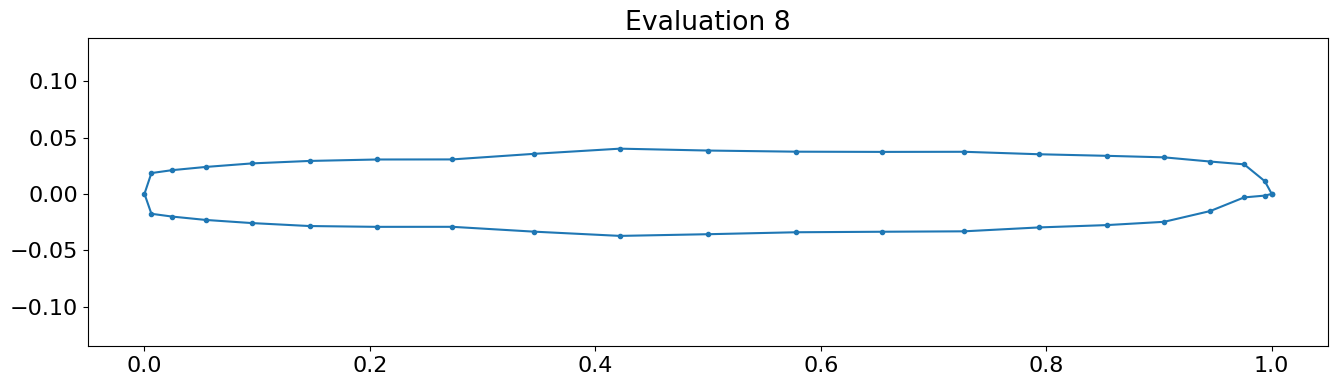

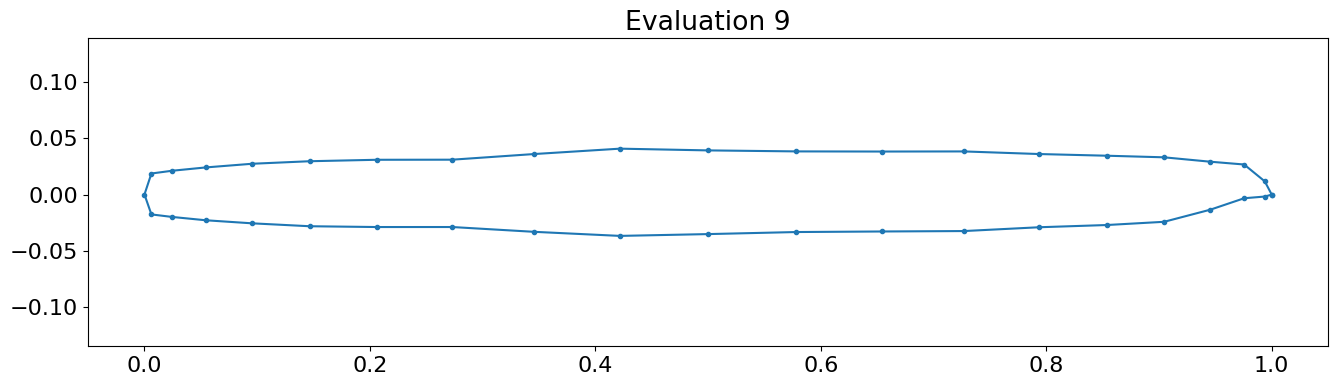

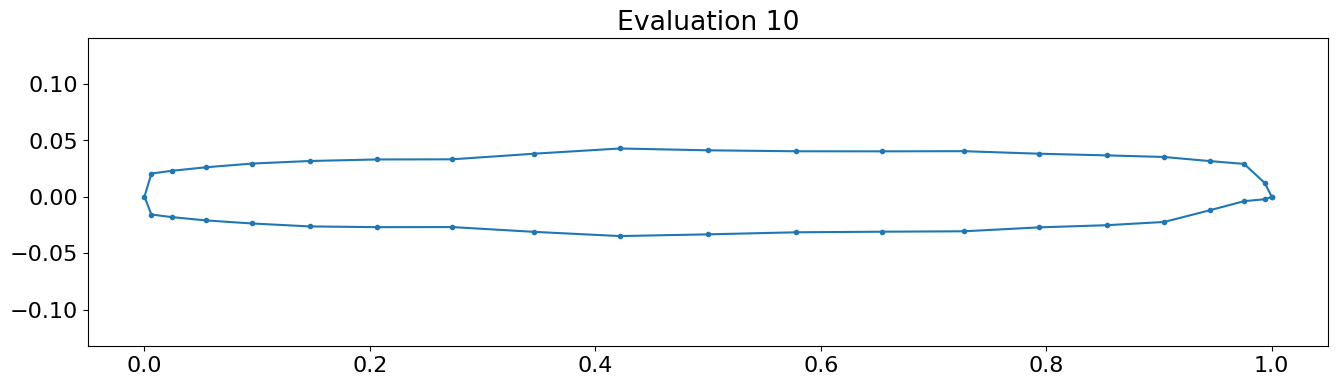

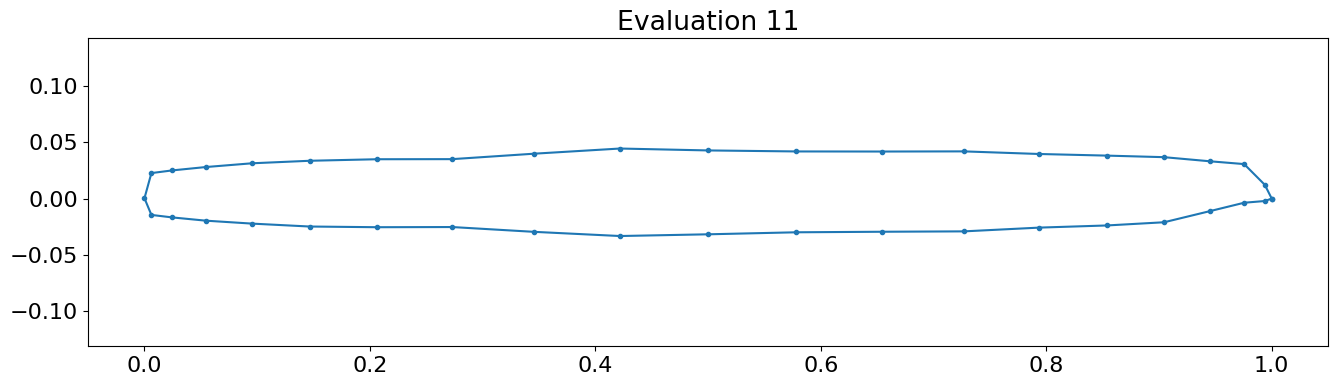

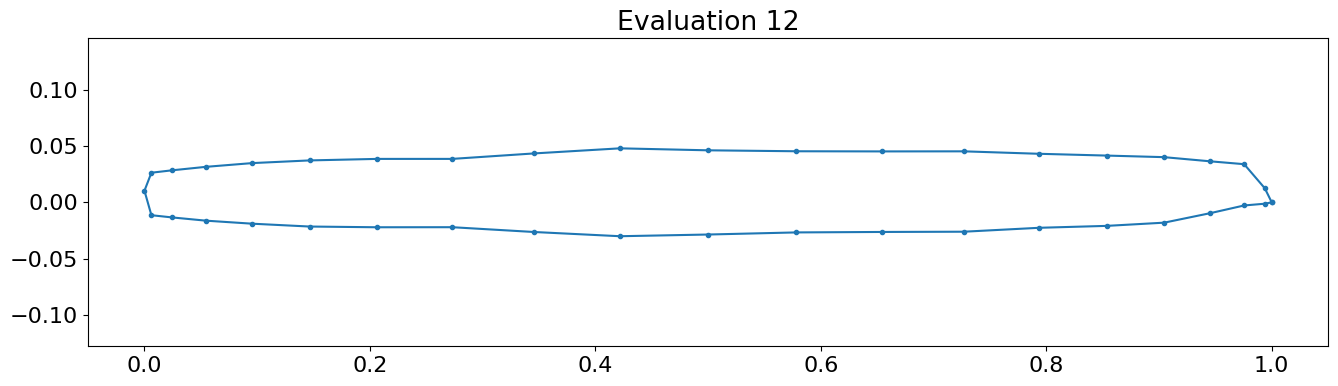

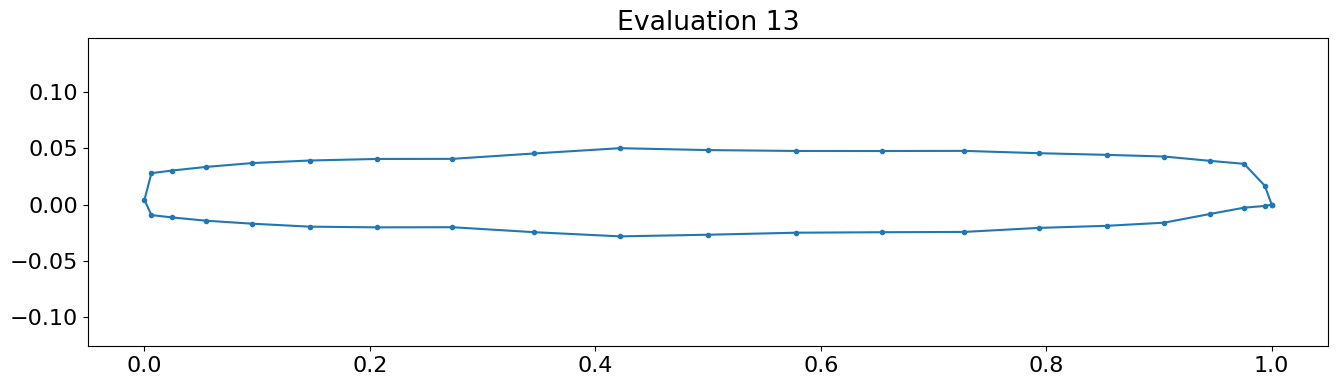

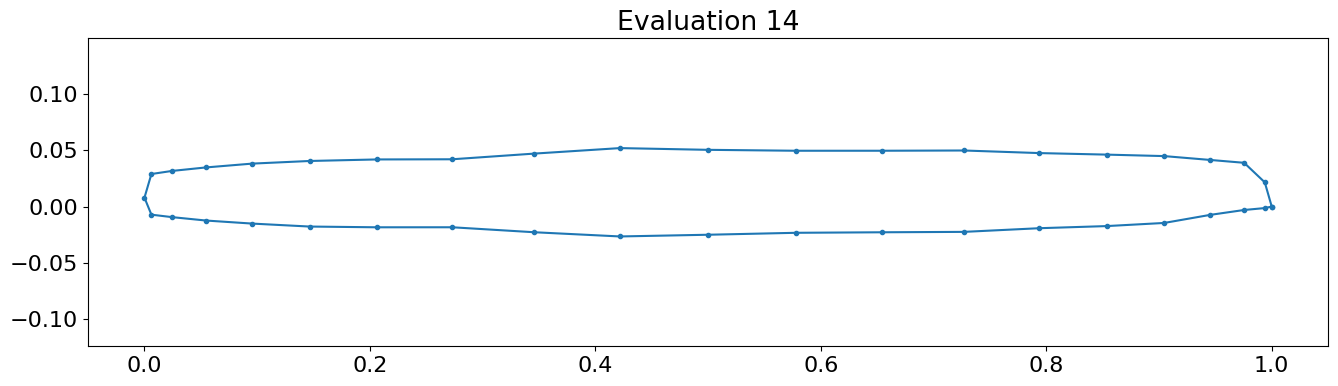

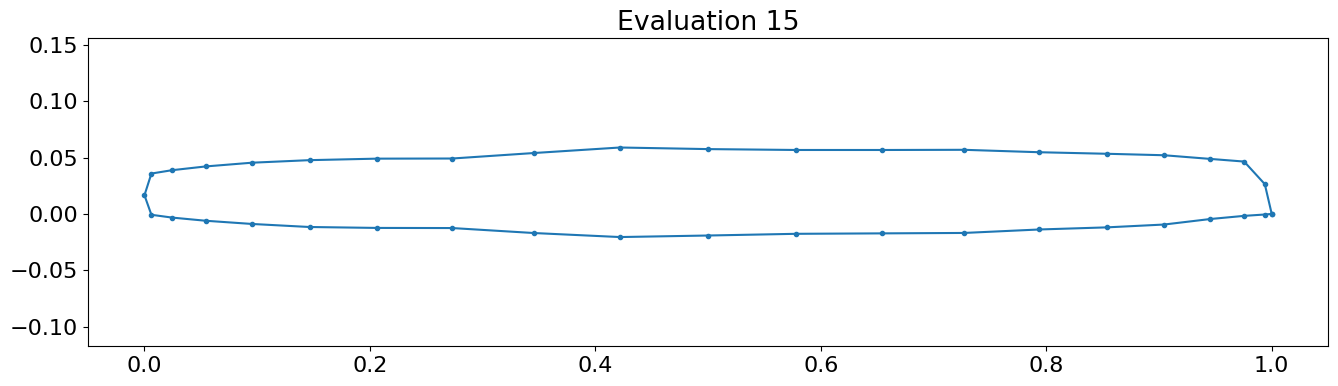

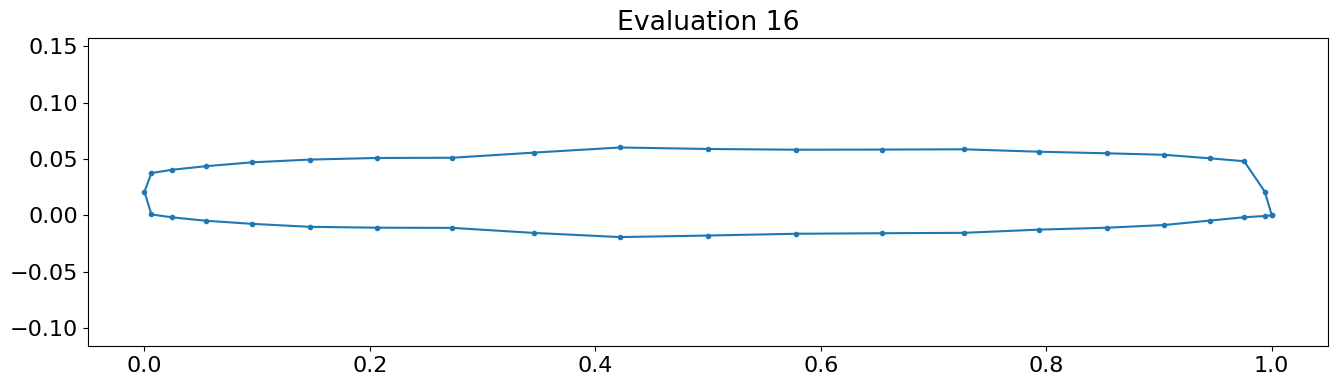

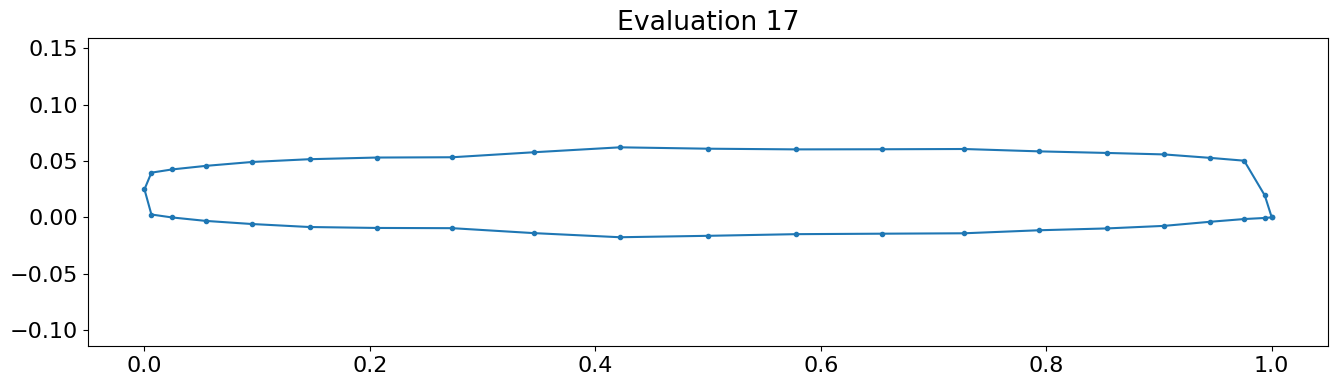

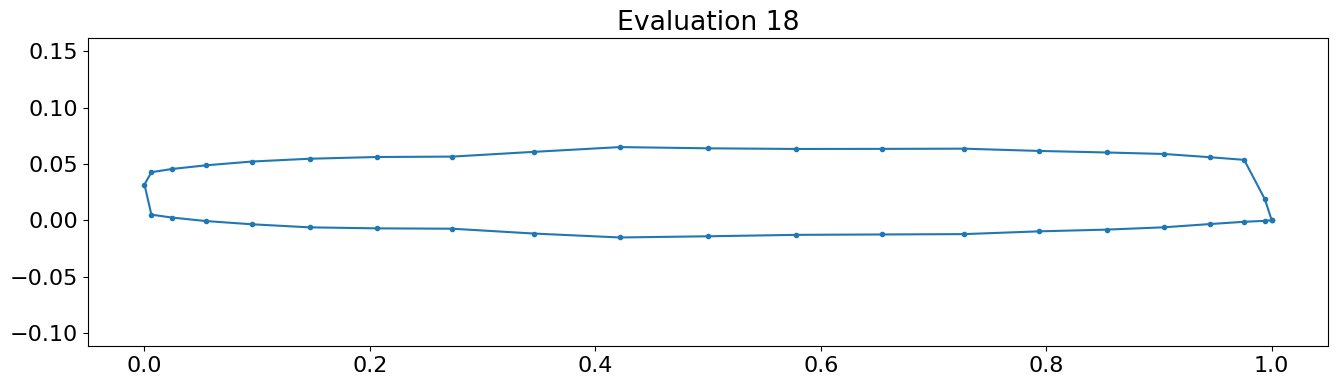

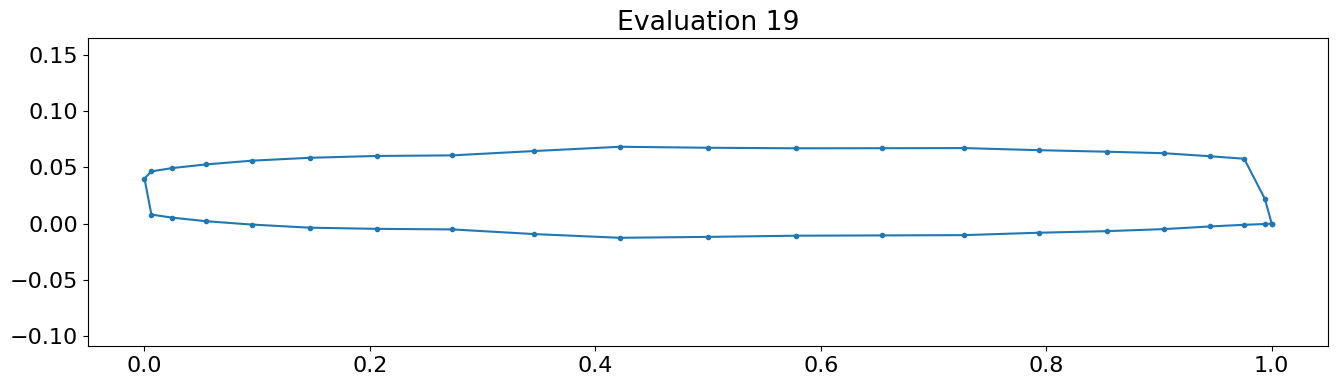

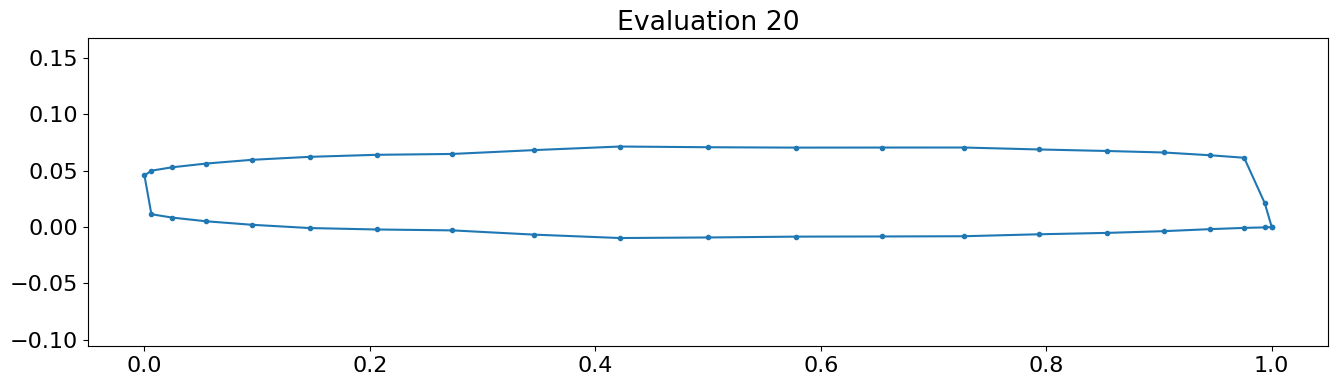

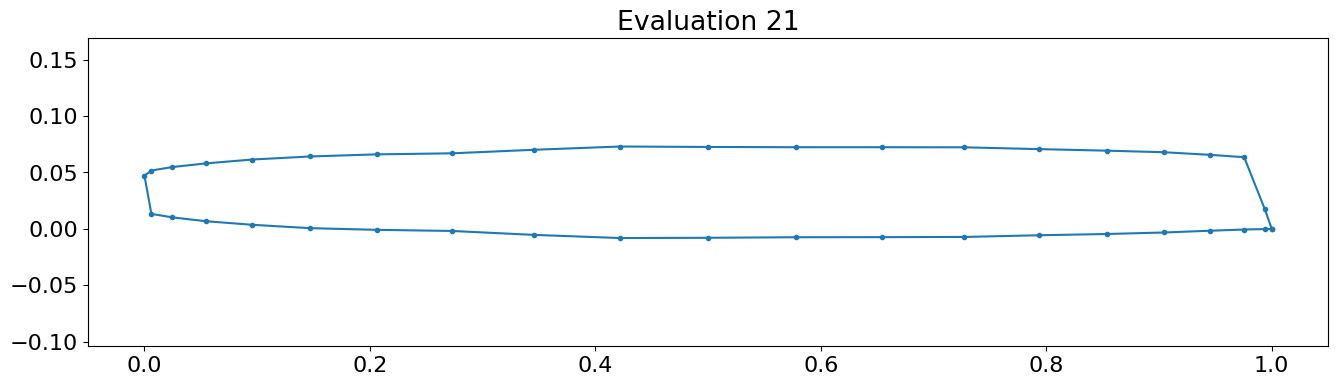

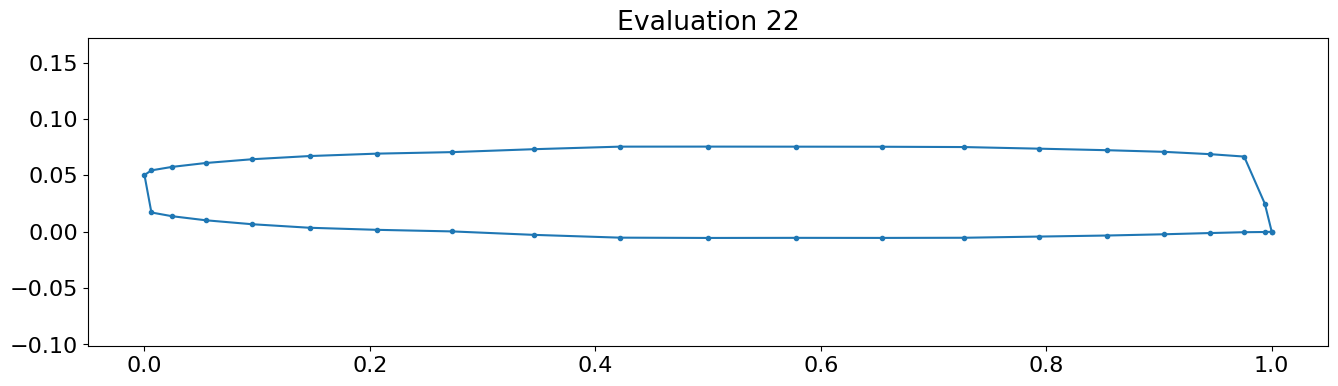

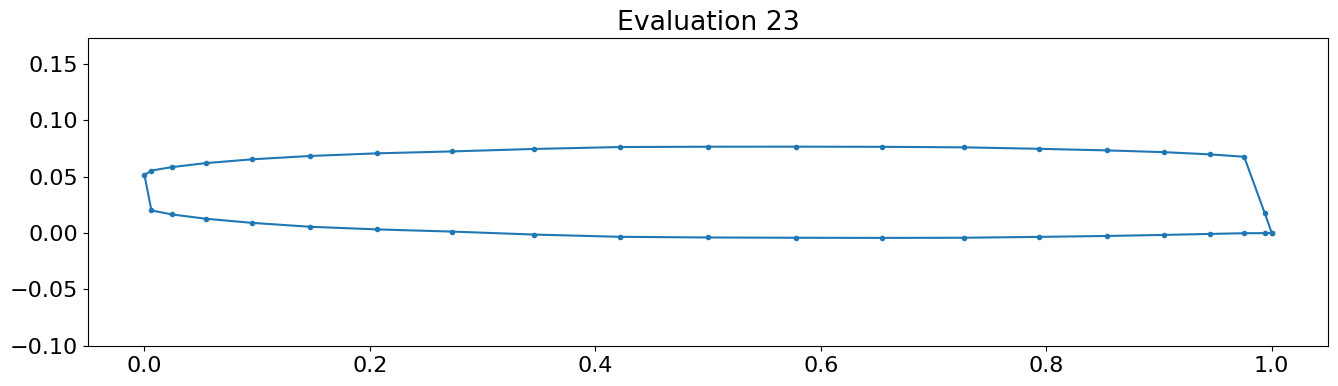

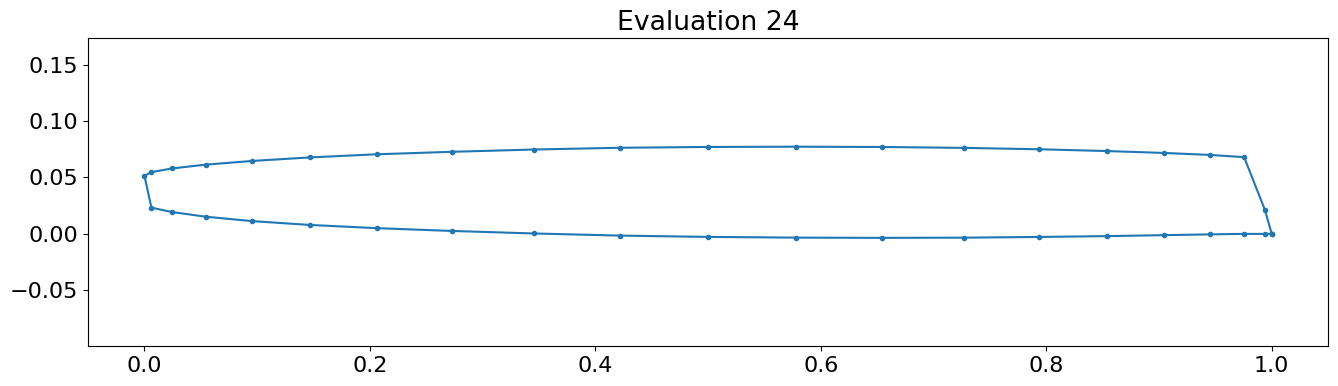

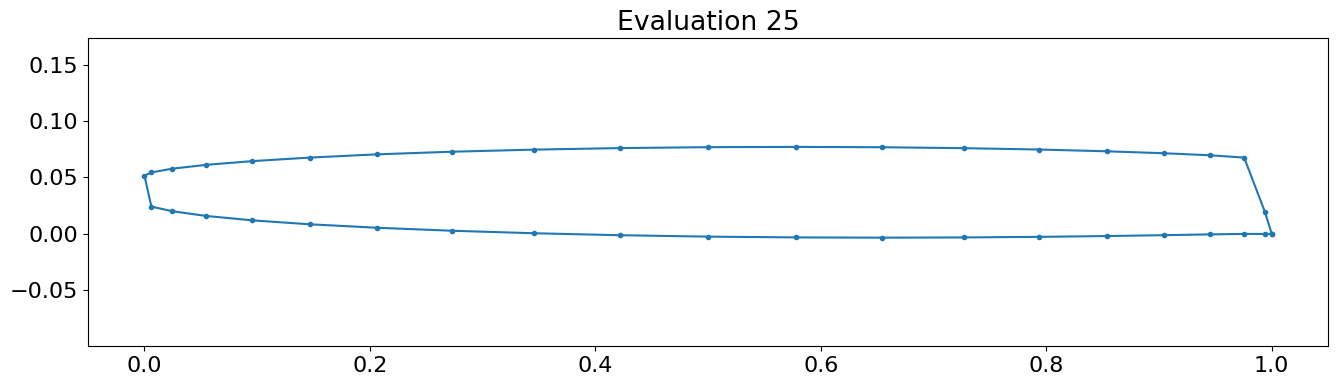

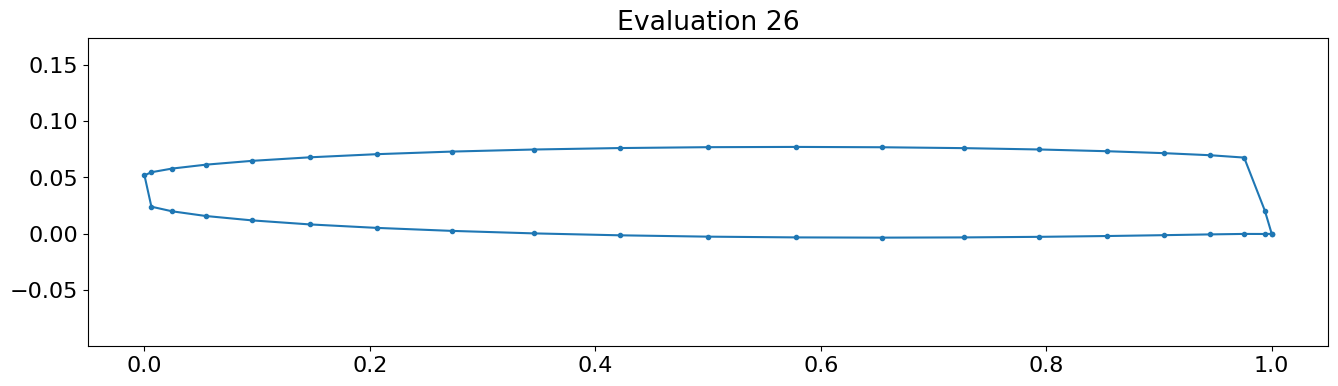

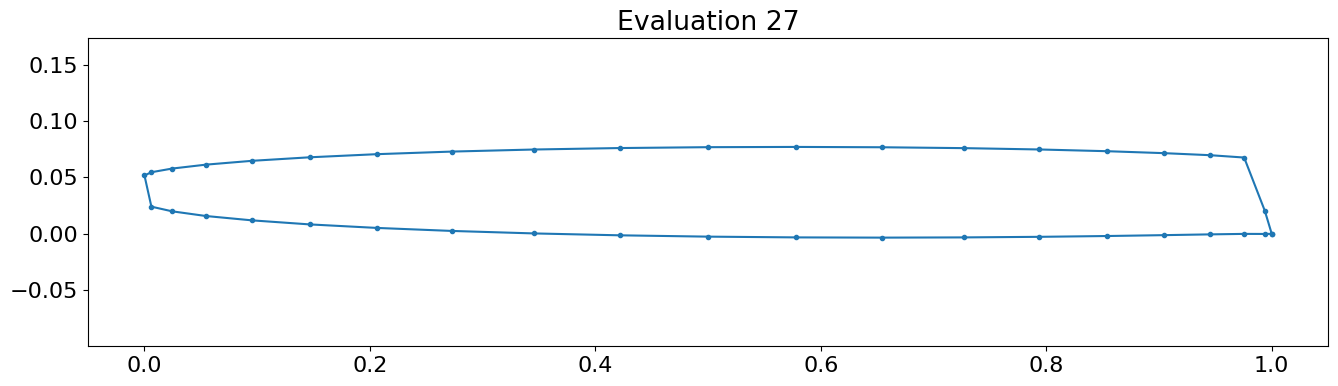

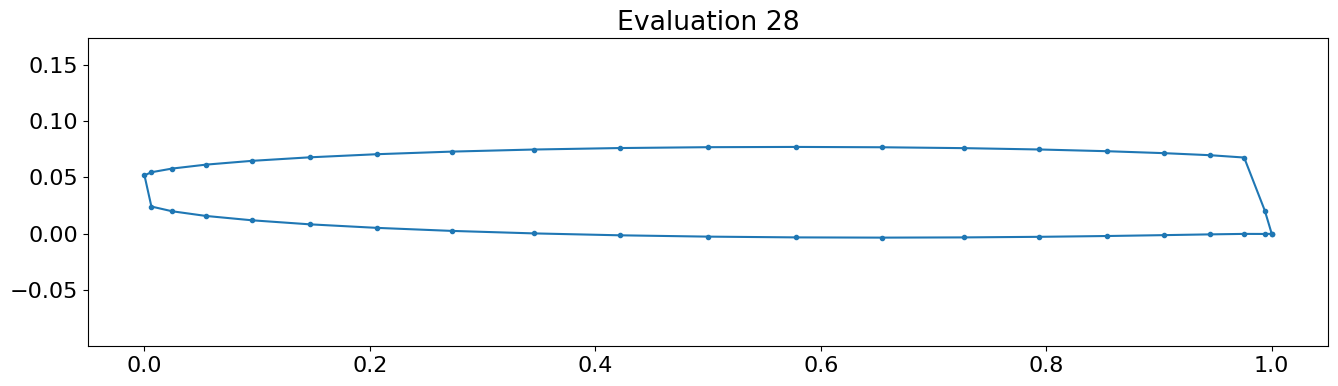

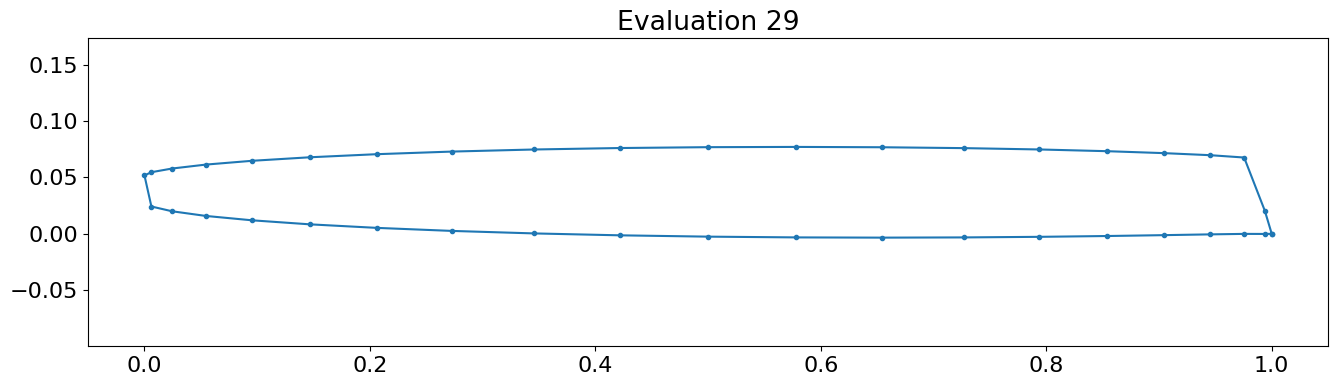

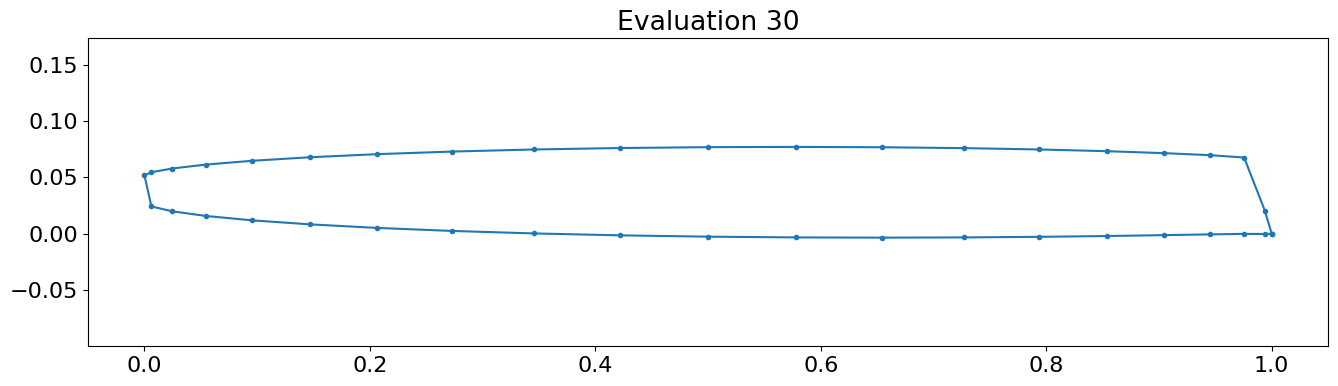

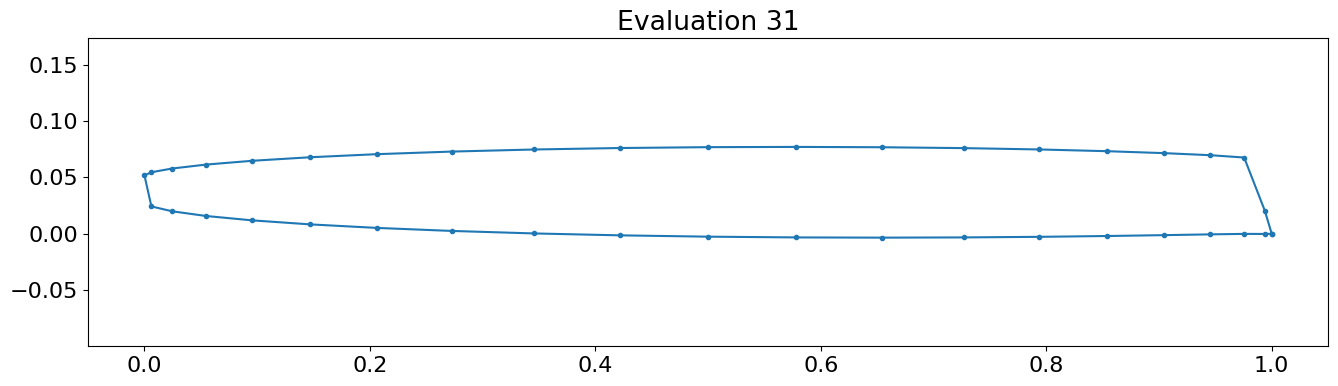

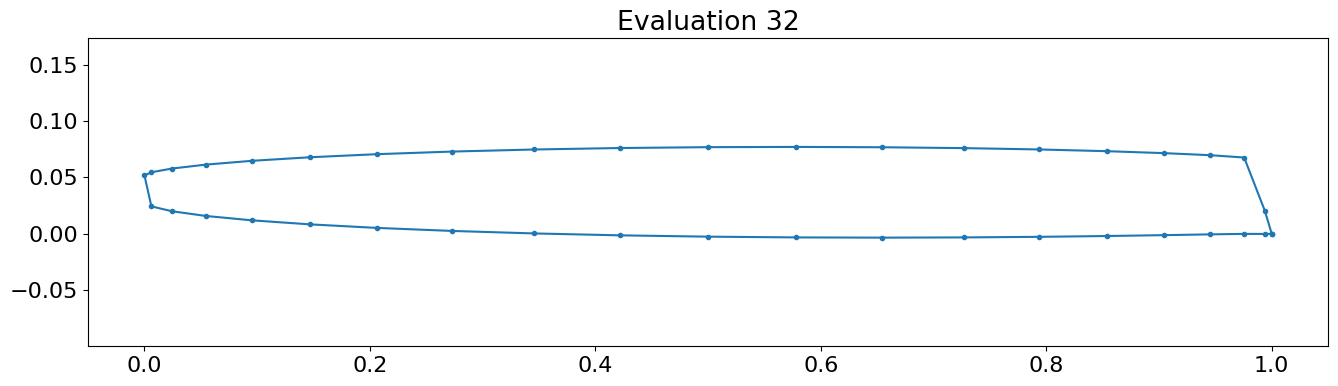

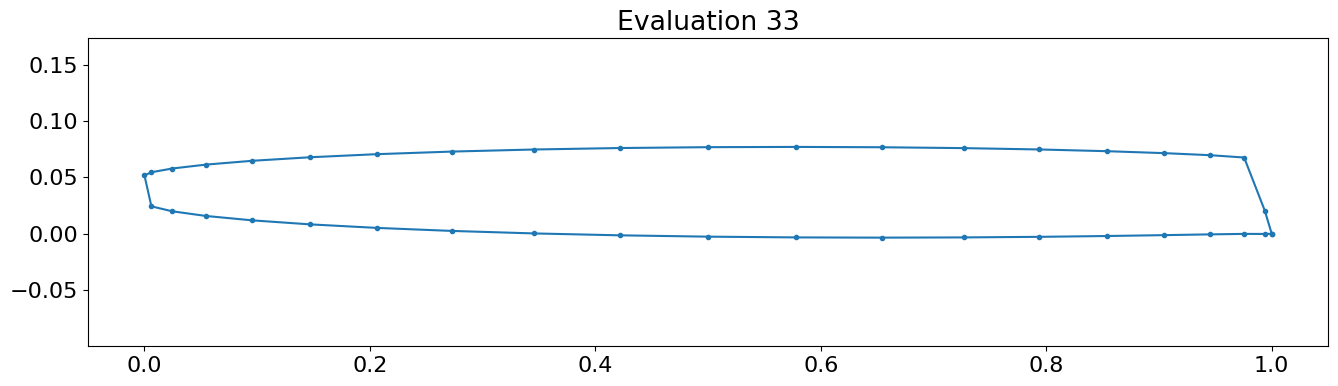

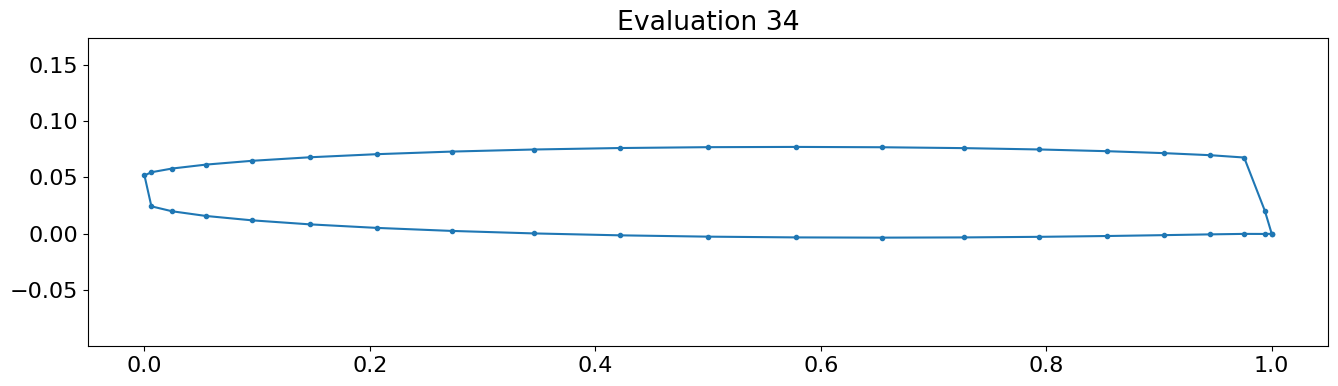

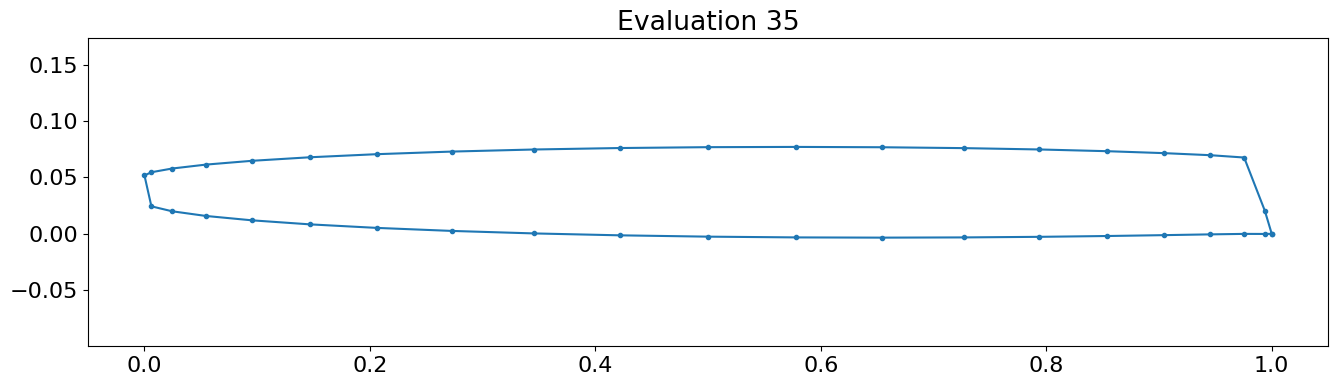

In [17]:
for i, x in enumerate(so.x_i[::10]):
    plt.figure(figsize=(16,4))
    plt.plot(x[:,0], x[:,1], '.-')
    plt.axis('equal')
    plt.title('Evaluation {}'.format(i))
    plt.show()

The lift coefficient:

In [18]:
x = so.x  # this is the last iterate

# recompute sigma:
pfpm = PotentialFlowPanelMethod(x, u_inf, alpha)
A, b = pfpm.assemble()
sigma = sl.solve(A, b)


print(af.lift(sigma, x))

1.9650309436011508


And plotting the flow solution:

C_L (PM): 1.9583554439322295


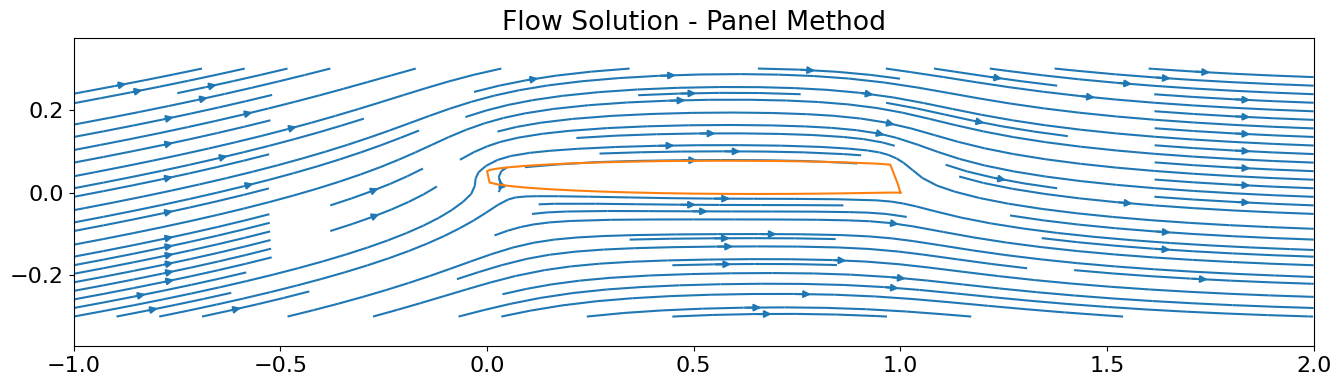

In [19]:
plt.figure(figsize=(16,4))
xg, yg = np.meshgrid(np.linspace(-1, 2, 40), np.linspace(-.3,.3, 40))
pfpm.plot_solution(sigma, xg, yg)
plt.title('Flow Solution - Panel Method')
plt.axis('equal');

print("C_L (PM):", pfpm.lift_coeffcient(sigma))

## Background: Penalty Term Based on Shape Factor (\*)

In the tutorial of lecture L9, we studied the shape factor $Q=l/\sqrt{A}$ where $l$ is the length (perimeter) around the airfoil cross section and $A$ its area. As it turns out this factor is a useful penalty term. Airfoils that are either to thin, or too thick in the vertical direction would encur a large value for $Q$ and thus not be considered optimal. Since we want to control the ratio between thickness and the distance between front and back (the "aspect ratio"), at the end of the tutorial notebook L9 we introduced the functions `shape_factor_ar` and `grad_shape_factor_ar`, which depend on a configurable parameter `aspect_ratio`.

For the penalty term we need to choose a parameter $Q_{\text{max}}$ that is roughly the maximal allowable value for Q. By using a term of the form $-\log(Q_{\text{max}}-Q)$, the penalty grows rapidly as $Q$ approaches $Q_{\text{max}}$ from below. We want the optimisation to be able to deal with shapes that start out with a value of $Q$ bigger than $Q_{\text{max}}$ as well though. This requires that the penalty keeps on increasing for $Q>Q_{\text{max}}$, so that the optimisation algorithm knows to take a search direction in which the penalty term and thus $Q$ decreases. For this reason, we cap the $-\log(Q_{\text{max}}-Q)$-term if $Q$ gets very close to $Q_{\text{max}}$, and continue the penalty linearly, with the same slope, for larger $Q$. All in all this means, that the penalty takes the following form:

$$
   \text{penalty}(Q(\vec x)) =
   \begin{cases}
     -Q_{\text{scale}} \log(Q_{\text{max}}-Q(\vec x)) & \text{for}\; Q(\vec x)\lt Q_{\text{max}} - Q_{\text{eps}} \\
     Q_{\text{scale}} \left(\log(Q_{\text{eps}}) + \frac{Q(\vec x)-(Q_{\text{max}} - Q_{\text{eps}})}{Q_{\text{eps}}}\right) & \text{for}\; Q(\vec x)\ge Q_{\text{max}} - Q_{\text{eps}} \\
   \end{cases},
$$

where $Q_{\text{eps}}$ is the distance to $Q_{\text{max}}$ at which the $\log$-term is capped, $Q_{\text{scale}}$ is an overall scaling of the penalty term. Its derivative takes the following simple form:

$$
  \frac{\partial \text{penalty}(Q(\vec x))}{\partial\vec x} = \frac{Q_{\text{scale}}}{\max(Q_{\text{max}}-Q(\vec x), Q_{\text{eps}})} \frac{\partial Q(\vec x)}{\partial\vec x}
$$

The derivative $\frac{\partial Q}{\partial\vec x}$ is calculated in `grad_shape_factor_ar` using the `grad_shape_factor` you have developed in tutorial notebook L9.